Day 3: Stellar encounters

- Today we will calculate the nearest encounters to the sun in the near future and past ~10Myr from the Gaia data and try to assess how many encounters we miss. We mainly redo the analysis of [Bailer-Jones+ 2018](http://adsabs.harvard.edu/abs/2018A%26A...616A..37B) and extend the analysis.
- find the closest encounter in LMA
- look at CMD
- clean sample with RUWE
- look at the closest encounters and check quadratic behaviour with distance
- propagate error lma for Gliese and for bigger sample
- calculate orbit
- propagate error orbit
- lma vs orbit (complete mock calculation)
- compare values with paper
- [make some orbit/integration tests]
- completeness analysis lma
- follow-up observational campaign targets

Resources:
- [Galactic potential](https://galpy.readthedocs.io/en/v1.4.0/potential.html)
- [Orbit integration](https://galpy.readthedocs.io/en/v1.4.0/orbit.html)
- [Stellar encounter paper](http://adsabs.harvard.edu/abs/2018A%26A...616A..37B)
- [Linear motion approximation](http://adsabs.harvard.edu/abs/2015A%26A...575A..35B)
- [Parallax zero-point](https://www.aanda.org/articles/aa/abs/2018/08/aa32727-18/aa32727-18.html)
- [Healpixel](https://healpix.jpl.nasa.gov/)

In [85]:
# For reproducability we will write out the versions of the libraries 
%load_ext version_information
%version_information numpy, matplotlib, astropy, scipy, galpy, healpy

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 3.6.3 64bit [GCC 7.2.0]
IPython 6.1.0
OS Linux 4.12.14 lp150.12.4 default x86_64 with glibc2.9
numpy 1.15.0
matplotlib 2.2.3
astropy 3.0.4
scipy 1.1.0
galpy 1.4.0
healpy 1.11.0
Wed Oct 10 16:52:00 2018 CEST

To get an introduction lets look at the currently closest stars to the sun:

![Nearest stars](https://upload.wikimedia.org/wikipedia/commons/8/88/PIA18003-NASA-WISE-StarsNearSun-20140425-2.png)
Credit: [NASA/Penn State University](http://photojournal.jpl.nasa.gov/catalog/PIA18003)

The spatial extent of the Oort cloud (a reservoir of asteroids) is also indicated. If stars come too close to the sun, they can perturb the Oort cloud and direct asteroid's orbits to the inner solar system. But at present time no star is close enough. Let's have a look at the near future:

![Distance over time](https://upload.wikimedia.org/wikipedia/commons/e/e9/Near-stars-past-future-en.svg)
Credit: [FrancescoA](https://commons.wikimedia.org/w/index.php?curid=15486327) - Near-stars-past-future-de.svg, CC BY-SA 3.0

In essence: no close encounter in the next 80k years.

Now let's do this for a longer time base (on the order of 10Myr) for as many stars as possible with the Gaia data:

![total motion](http://sci.esa.int/science-e-media/img/1f/Proper_motion_2000px.jpg)
Credit: ESA / ATG medialab

Therefore we need RVS data. Short recap on the focal plane:

![focal plane](http://home.strw.leidenuniv.nl/~brown/images/G-EA-2006-5-low.jpg)

We should also keep in mind that the radial velocity measurement is only available for a subset (7.2mio) of stars with ~G<13.

From [Bailer-Jones 2015](http://adsabs.harvard.edu/abs/2015A%26A...575A..35B) we get the time and distance of closest approach (perihelion) under linear motion approximation (lma):

![equation](pics/formula_lma.png)

which can be translated into an ADQL query to only retrieve stars that come closer than 10pc:
```SQL
SELECT * 
FROM gaiadr2.gaia_source
WHERE (parallax IS NOT NULL) AND (parallax > -0.029)
    AND (radial_velocity IS NOT NULL)
    AND((( 1000*4.74047*sqrt(power(pmra,2)+power(pmdec,2))/ power(parallax+0.029,2))/ 
    sqrt((power(pmra,2)+power(pmdec,2))* power(4.74047/(parallax+0.029),2) + power(radial_velocity,2))) < 10)
```

In [86]:
%pylab inline
from astropy.io import fits
from numpy.lib.recfunctions import append_fields
from astropy.coordinates import SkyCoord
from astropy.time import Time
import astropy.units as u
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014, DehnenBarPotential, plotPotentials, plotDensities
import time
import healpy as hp
from plotting import plot_hrd, plot_mollweide, plot_encounter, plot_lma_vs_orbit, plot_comparison_orbit, plot_mollweide_log
from utility import grvs_for_blue_sources, grvs_for_red_sources, compute_ruwe, linear_motion_approximation, sample_gaia_uncertainty, linear_motion_approximation_split_input, orbit_distance, sample_gaia_uncertainty_5d, hpx_prior_rvs, hpx_density, hpx_statistic, gaia_hpx_factor, number_of_healpixels

Populating the interactive namespace from numpy and matplotlib
/home/rybizki/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['percentile', 'sort', 'dist', 'mean', 'std']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"



In [87]:
# Loading Gaia data from CDS
x = fits.getdata("../data/day_3/gdr2_lma_cds_all_10/gdr2_lma_10.fits")
print(len(x),x.dtype)
# We add extra fields to store derived quantities like the perihelion distance and time.
x = append_fields(x, ['phot_rvs_mean_mag','lma_min_distance','total_velocity','lma_min_time','orbit_min_distance','orbit_min_time', 'ruwe'],(np.zeros(len(x)),np.zeros(len(x)),np.zeros(len(x)),np.zeros(len(x)),np.zeros(len(x)),np.zeros(len(x)),np.zeros(len(x))),usemask=False, asrecarray=True)
# Add zeropoint correction of the parallax
x.parallax = x.parallax + 0.029


3865 (numpy.record, [('designation', 'S28'), ('ra', '>f8'), ('ra_error', '>f4'), ('dec', '>f8'), ('dec_error', '>f4'), ('solution_id', '>i8'), ('source_id', '>i8'), ('random_index', '>i8'), ('ref_epoch', '>f4'), ('parallax', '>f8'), ('parallax_error', '>f4'), ('parallax_over_error', '>f8'), ('pmra', '>f8'), ('pmra_error', '>f4'), ('pmdec', '>f8'), ('pmdec_error', '>f4'), ('ra_dec_corr', '>f4'), ('ra_parallax_corr', '>f4'), ('ra_pmra_corr', '>f4'), ('ra_pmdec_corr', '>f4'), ('dec_parallax_corr', '>f4'), ('dec_pmra_corr', '>f4'), ('dec_pmdec_corr', '>f4'), ('parallax_pmra_corr', '>f4'), ('parallax_pmdec_corr', '>f4'), ('pmra_pmdec_corr', '>f4'), ('astrometric_n_obs_al', '>i2'), ('astrometric_n_obs_ac', '>i2'), ('astrometric_n_good_obs_al', '>i2'), ('astrometric_n_bad_obs_al', '>i2'), ('astrometric_gof_al', '>f8'), ('astrometric_chi2_al', '>f8'), ('astrometric_excess_noise', '>f4'), ('astrometric_excess_noise_sig', '>f8'), ('astrometric_params_solved', '>i2'), ('astrometric_primary_flag',

In [88]:
# We also load the same query for the GDR2mock catalogue.
# Since all radial velocities are known in GDR2mock we will get many more stars
y = np.load('../data/day_3/gdr2mock_lma_all_10/result.npy')
print(len(y),y.dtype)
# We add extra fields to store derived quantities like the perihelion distance and time.
y = append_fields(y, ['lma_min_distance','total_velocity','lma_min_time','orbit_min_distance','orbit_min_time'],(np.zeros(len(x)),np.zeros(len(x)),np.zeros(len(x)),np.zeros(len(x)),np.zeros(len(x))),usemask=False, asrecarray=True)
# No need for a zero-point correction with the mock data because the parallaxes are perfect

39841 [('source_id', '<i8'), ('ra', '<f8'), ('dec', '<f8'), ('ra_error', '<f4'), ('dec_error', '<f4'), ('pmra', '<f4'), ('pmdec', '<f4'), ('pmra_error', '<f4'), ('pmdec_error', '<f4'), ('parallax', '<f4'), ('parallax_error', '<f4'), ('phot_g_mean_mag', '<f4'), ('phot_g_mean_flux', '<f8'), ('phot_g_mean_flux_error', '<f4'), ('phot_rp_mean_flux', '<f8'), ('phot_rp_mean_flux_error', '<f4'), ('phot_rp_mean_mag', '<f4'), ('phot_bp_mean_flux', '<f8'), ('phot_bp_mean_flux_error', '<f4'), ('phot_bp_mean_mag', '<f4'), ('phot_rp_bp_excess_factor', '<f4'), ('radial_velocity', '<f4'), ('radial_velocity_error', '<f4'), ('astrometric_gof_al', '<f4'), ('astrometric_params_solved', '<f4'), ('random_index', '<i8'), ('l', '<f8'), ('b', '<f8'), ('phot_g_n_obs', '<i2'), ('phot_variable_flag', 'O'), ('phot_rp_n_obs', '<i2'), ('phot_bp_n_obs', '<i2'), ('bp_rp', '<f4'), ('bp_g', '<f4'), ('g_rp', '<f4'), ('phot_rvs_mean_mag', '<f4'), ('rv_nb_transits', '<i2'), ('ref_epoch', '<f8'), ('astrometric_delta_q', '<f

In order to make both samples similar we will try to apply the same magnitude cut. The completeness limit is more inclusive if we cut in G<sub>RVS</sub> instead of G magnitude. Compare the following two figures:

![Completeness in G](pics/rvs_completeness_in_g.png)

In G we can go up to 12.5th magnitude but that would only include 3.7mio stars

![Completeness in G_rvs](pics/rvs_completeness_in_grvs.png)

In G<sub>RVS</sub> we can go down to 12th mag which includes 5.5mio stars

In [89]:
# Therefore we derive G_rvs from a simple transformation given in equation 2 and 3 from (https://www.aanda.org/component/article?access=doi&doi=10.1051/0004-6361/201833051)
gmrp = x.phot_g_mean_mag - x.phot_rp_mean_mag
blue_cut = (gmrp<1.4) 
x.phot_rvs_mean_mag[blue_cut] = grvs_for_blue_sources(x.phot_g_mean_mag[blue_cut],x.phot_rp_mean_mag[blue_cut])
red_cut = (gmrp>=1.4) 
x.phot_rvs_mean_mag[red_cut] = grvs_for_red_sources(x.phot_g_mean_mag[red_cut],x.phot_rp_mean_mag[red_cut])
# and cut for all stars brighter than G_rvs = 12
print('all data: ',len(x))
grvs_cut = (x.phot_rvs_mean_mag<12)
data = x[grvs_cut]
print('with grvs_cut: ', len(data))
# We also clean the sample from spurious sources
x.ruwe = compute_ruwe(x)
astro_cut = (x.ruwe<1.4)

# apply both cuts and look at the number of sources left
data = x[grvs_cut & astro_cut]
print('with G_rvs and astrometry cut', len(data))


/home/rybizki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until

/home/rybizki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """

all data:  3865
with grvs_cut:  3516
with G_rvs and astrometry cut 2353


In [90]:
# Now we do similar cuts to the GDR2mock catalogue:
# First we cut in G_rvs which is already provided with GDR2
cut_grvs_mock = (y.phot_rvs_mean_mag < 12)

# And we also exclude stars outside the temperature range for which radial velocities could be derived in DR2 
# (the spectroscopic lines from which the radial velocities are measured get weaker outside this temperature range)
cut_teff = (y.teff_val < 6900) & (y.teff_val > 3550)
print('all mock data: ',len(y))
mock_data = y[cut_grvs_mock]
print('with G_rvs cut: ',len(mock_data))
mock_data = y[cut_grvs_mock & cut_teff]
print('with G_rvs and temperature cut: ',len(mock_data))


all mock data:  39841
with G_rvs cut:  4613
with G_rvs and temperature cut:  3129


/home/rybizki/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))



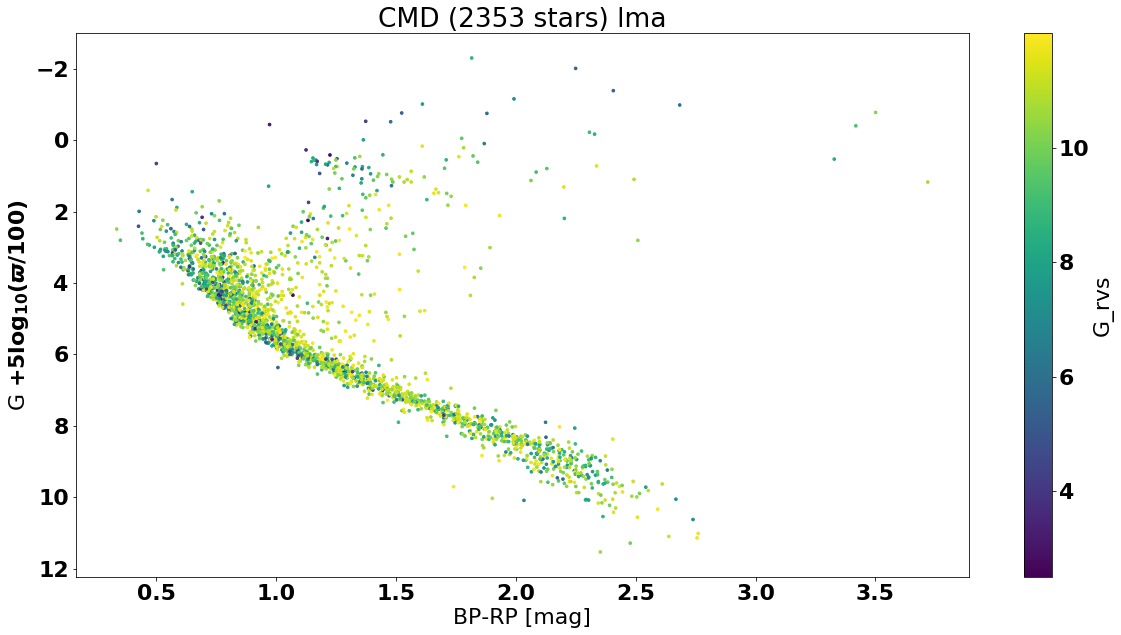

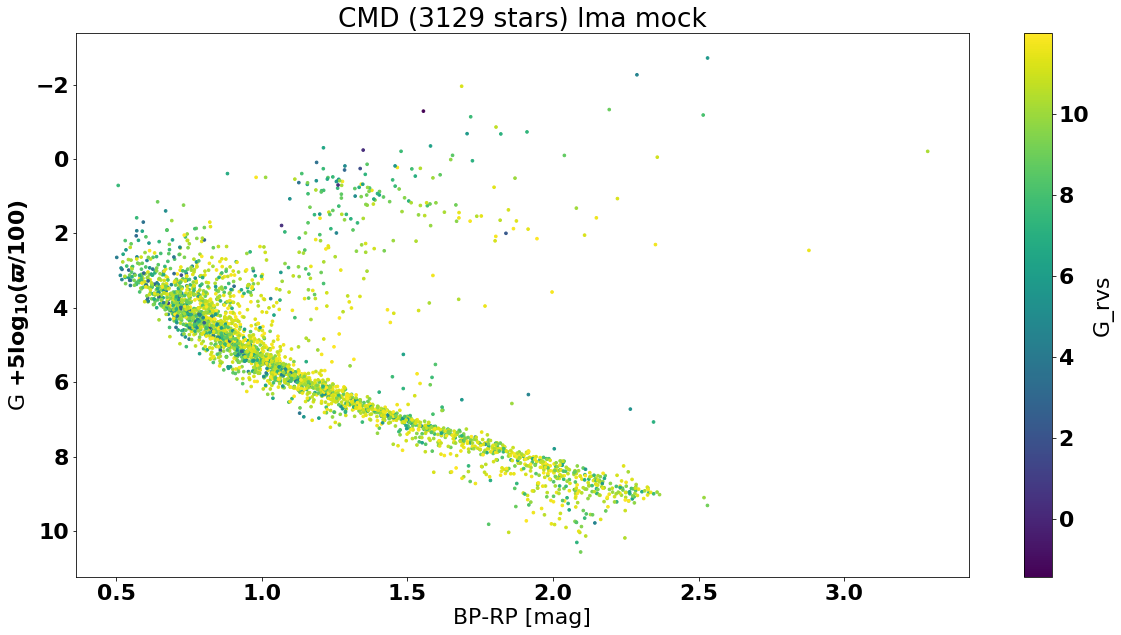

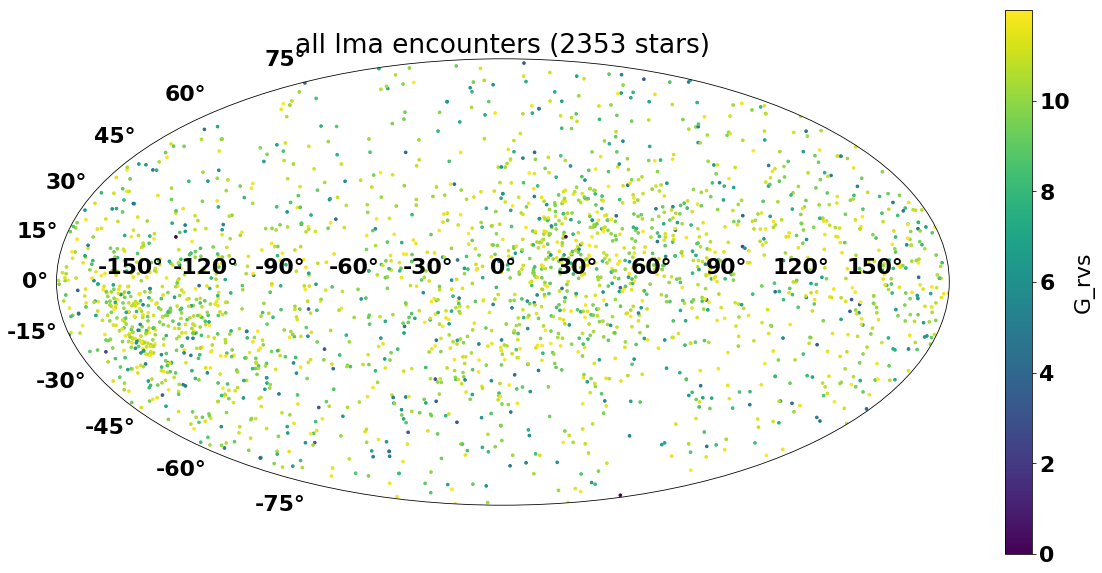

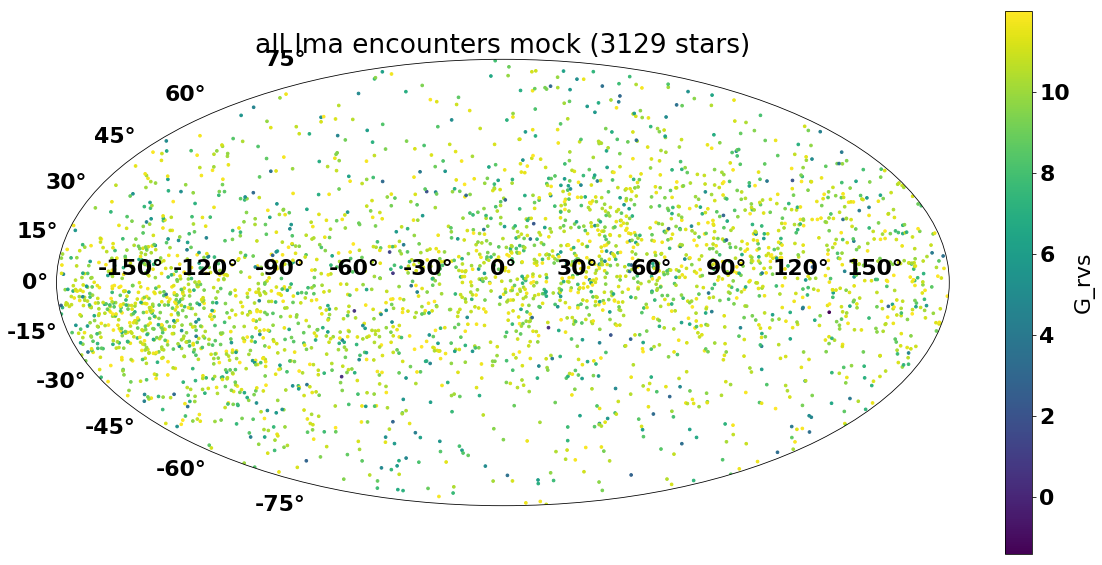

In [91]:
# We use a bigger font for you to see better on the beamer
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
matplotlib.rc('font', **font)
# Now we plot both samples in HRD and projected on the sky:
plot_hrd(data,'lma',data.phot_rvs_mean_mag,'G_rvs')
plot_hrd(mock_data,'lma mock',mock_data.phot_rvs_mean_mag,'G_rvs')
plot_mollweide(data.l,data.b,data.phot_rvs_mean_mag,'G_rvs','all lma encounters')
plot_mollweide(mock_data.l,mock_data.b,mock_data.phot_rvs_mean_mag,'G_rvs','all lma encounters mock')

In [92]:
# Here we calculate their closest approach, time of perihelion and their speed according to the linear motion approximation
x.lma_min_distance, x.total_velocity, x.lma_min_time = linear_motion_approximation(x)
y.lma_min_distance, y.total_velocity, y.lma_min_time = linear_motion_approximation(y)

/home/rybizki/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))



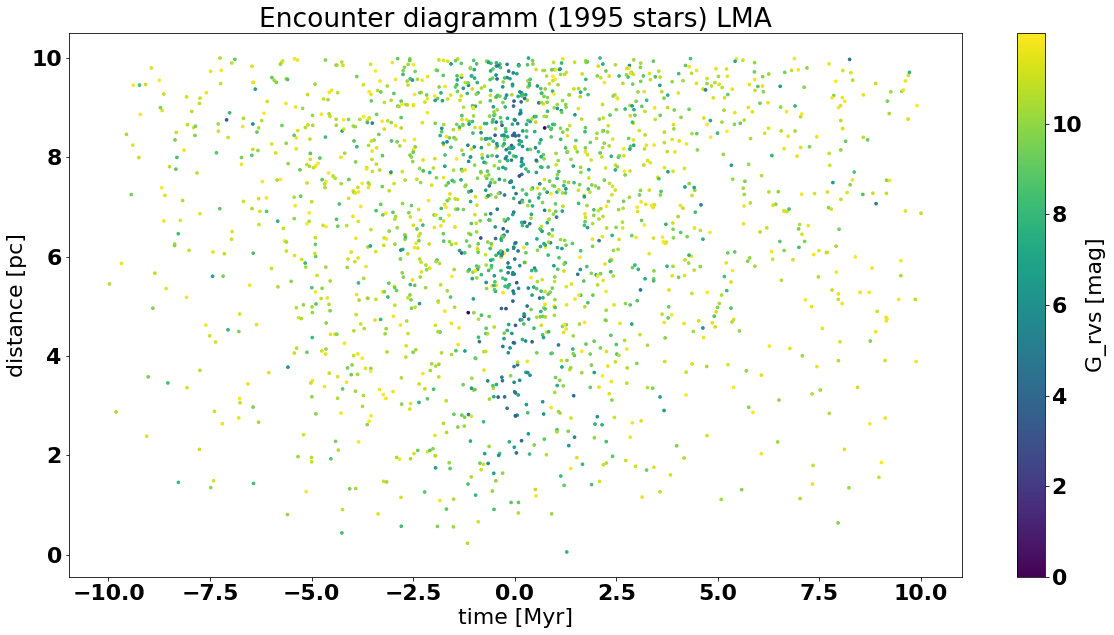

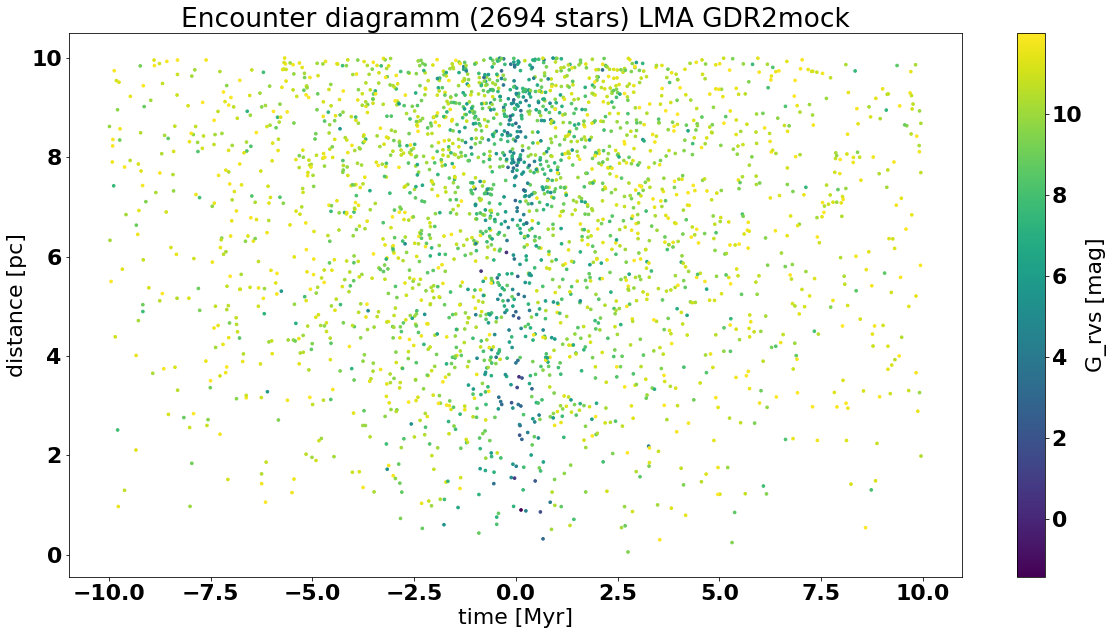

In [93]:
# Now we can also cut in time because the further away in time, the worse is the lma approximation
# Also far away events are less interesting than stars that approach us in shorter periods of time
# So we look at the closest encounters that happen within 10Myr 
time_cut = (np.abs(x.lma_min_time) < 10)
data = x[grvs_cut & astro_cut & time_cut]
time_cut_mock = (np.abs(y.lma_min_time) < 10)
mock_data = y[cut_grvs_mock & cut_teff & time_cut_mock]

# And we plot their distribution in perihelion distance and time
plot_encounter(data,'LMA',data.phot_rvs_mean_mag,'G_rvs [mag]')
plot_encounter(mock_data,'LMA GDR2mock',mock_data.phot_rvs_mean_mag,'G_rvs [mag]')

In [95]:
# Now we look at the stars that come within 1pc, order them by perihelion distance and look at their properties 
cut_near = (data.lma_min_distance < 1)
sub = data[cut_near]
sub = np.sort(sub,order = 'lma_min_distance')
print('source_id       ','lma_min_distance','lma_min_time','parallax', 'total_velocity', 'radial_velocity','ra','dec')
for item in sub:
    print(item[['source_id','lma_min_distance','lma_min_time','parallax', 'total_velocity','radial_velocity','ra','dec']])

source_id        lma_min_distance lma_min_time parallax total_velocity radial_velocity ra dec
(4270814637616488064, 0.05445162, 1.28063204, 52.5475, 14.53005932, -14.53, 274.96183636, -1.93861271)
(5571232118090082816, 0.23010916, -1.16312636, 10.2294, 82.18022673, 82.18, 92.73103287, -42.76760772)
(2933503521200215424, 0.43809268, -4.25602398, 7.3259, 31.36016224, 31.36, 102.58670674, -18.62516247)
(1791617849154434688, 0.56029123, -1.51122423, 11.4939, 56.29116825, 56.29, 318.63712839, 21.89243365)
(6396469681261213568, 0.56941396, -1.90206507, 9.8289, 52.30081949, 52.3, 325.13130876, -69.42071711)
(510911618569239040, 0.57237445, -2.79363394, 13.232, 26.45075936, 26.45, 20.13165221, 61.88252167)
(2025919447734209280, 0.63903065, 7.95882871, 5.4748, 22.44013777, -22.44, 291.14269878, 27.41926141)
(5261593808165974784, 0.66228047, -0.89812816, 15.3214, 71.05366175, 71.05, 98.62243638, -74.82975426)
(5609641602602868864, 0.80695777, -5.59490103, 3.5893, 48.69020387, 48.69, 106.00018204

You can also check out your star in a common astronomy database: [Simbad](http://simbad.u-strasbg.fr/simbad/sim-fbasic), where you can look for their coordinates.

We can also compare this to the encounters found by the [Gaia DR2 stellar encounter paper](http://adsabs.harvard.edu/abs/2018A%26A...616A..37B):

![table 2](pics/table_2.png)

Input:
- Missing sources
- Difference because of orbit integration (we will adress that later)
- Error estimates (analytic vs numeric)

In [11]:
# Lets only work with Gliese710 the closest encounter for a moment:
gliese = sub[0]
field_names = ['ra', 'ra_error', 'dec', 'dec_error', 'source_id', 'parallax', 'parallax_error',
               'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'parallax_pmra_corr', 'parallax_pmdec_corr',
               'pmra_pmdec_corr', 'phot_g_mean_mag', 'phot_g_mean_mag_error',
               'phot_bp_mean_mag', 'phot_bp_mean_mag_error', 'phot_rp_mean_mag', 'phot_rp_mean_mag_error',
               'radial_velocity', 'radial_velocity_error', 'phot_rvs_mean_mag', 'lma_min_distance', 
               'total_velocity', 'lma_min_time', 'orbit_min_distance', 'orbit_min_time', 'ruwe']
# Lets have a look at a few interesting quantities of that star
for name in field_names:
    print(name, gliese[name])

ra 274.96183636341
ra_error 0.0428
dec -1.93861270951
dec_error 0.0435
source_id 4270814637616488064
parallax 52.54750000000001
parallax_error 0.0478
pmra -0.46
pmra_error 0.084
pmdec -0.028
pmdec_error 0.073
parallax_pmra_corr -0.1853
parallax_pmdec_corr 0.0833
pmra_pmdec_corr -0.0702
phot_g_mean_mag 9.0608
phot_g_mean_mag_error 0.0005
phot_bp_mean_mag 9.8957
phot_bp_mean_mag_error 0.0012
phot_rp_mean_mag 8.1997
phot_rp_mean_mag_error 0.003
radial_velocity -14.53
radial_velocity_error 0.44
phot_rvs_mean_mag 7.843779563903809
lma_min_distance 0.05445161878999502
total_velocity 14.53005932026149
lma_min_time 1.280632042732231
orbit_min_distance 0.0
orbit_min_time 0.0
ruwe 0.9854799984161288


# Task 1
#### Try to numerically propagate the error of the phasespace coordinates (parallax, pmra, pmdec, radial_velocity) of Gliese710 into the perihelion distance and time for the linear motion approximation.

#### Hints:
- Assume that the errors are Gaussian in parallax, pmra, pmdec, radial_velocity and uncorrelated. Sample them (sample size should be on the order of 1000) using [np.random.normal](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.normal.html).

- You will probably have to rewrite the utility function, ```linear_motion_approximation```, such that it can use your sampled quantities.
```python
def linear_motion_approximation(x):
    """
    Calculates from parallax, pmra, pmdec, radial_velocity via linear motion approximation the
        closest distance in pc
        total velocity in km/s
        time of closest approach in Myr
    """
    total_velocity = np.sqrt((x['pmra']**2 + x['pmdec']**2) * np.divide(4.74047,
        x['parallax'])**2 + x['radial_velocity']**2)
    closest_distance = np.divide(np.divide(1000*4.74047,x['parallax']**2) * 
        np.sqrt(x['pmra']**2 + x['pmdec']**2),total_velocity)
    closest_time = np.divide(-0.97779e9,x['parallax']) * np.divide(x['radial_velocity'],
        (x['pmra']**2 + x['pmdec']**2) * np.divide(4.74047,x['parallax'])**2 + x['radial_velocity']**2)
    return(closest_distance, total_velocity, np.divide(closest_time,1e6))
    ```
- Then try to give 5, 50 and 95 percentiles from the sampled perihelion distance / time (as is given in table) and compare those values to the values that we derived without using the error. Also compare to the values given in table 2 from above. You might want to use the [np.percentile](https://docs.scipy.org/doc/numpy/reference/generated/numpy.percentile.html) function for this.

/home/rybizki/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))



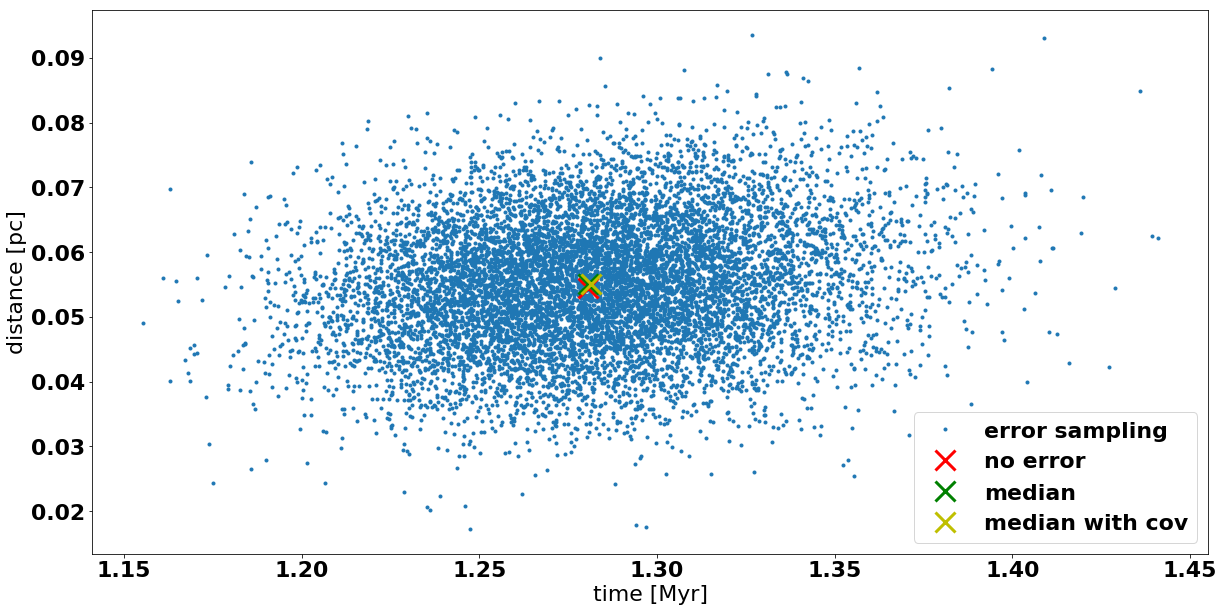

Min distance without error propagation:  0.05445161878999502
min dist percentile 5 (with , without covariance):  0.03904313300628521 0.038865168110711903
min dist percentile 50 (with , without covariance):  0.055137733731652996 0.055031773450964015
min dist percentile 95 (with , without covariance):  0.07147561220598607 0.07158574090978234
Min time without error propagation:  1.280632042732231
min time percentile 5 (with , without covariance):  1.2207619724084662 1.2198311528738268
min time percentile 50 (with , without covariance):  1.281295416384602 1.2805940469495631
min time percentile 95 (with , without covariance):  1.3478826596585147 1.3472211645119285


In [12]:
parallax,pmra,pmdec,radial_velocity = sample_gaia_uncertainty(gliese, n_sample = 10000)
min_dist,tot_vel,min_time = linear_motion_approximation_split_input(parallax,pmra,pmdec,radial_velocity)
parallax,pmra,pmdec,radial_velocity = sample_gaia_uncertainty(gliese, n_sample = 10000, no_correlation = True)
min_dist_nc,tot_vel_nc,min_time_nc = linear_motion_approximation_split_input(parallax,pmra,pmdec,radial_velocity)

plt.figure(figsize = (20,10))
#plt.plot(min_time_nc,min_dist_nc,'.', label = 'without covariance')
plt.plot(min_time,min_dist,'.', label = 'error sampling')
plt.plot(gliese.lma_min_time,gliese.lma_min_distance,'rx',ms = 20, mew=3, label = 'no error')
plt.plot(np.median(min_time_nc),np.median(min_dist_nc),'gx', ms = 20, mew=3, label = 'median')
plt.plot(np.median(min_time),np.median(min_dist),'yx', ms = 20, mew=3, label = 'median with cov')
plt.legend()
plt.ylabel('distance [pc]')
plt.xlabel('time [Myr]')
plt.show()
print('Min distance without error propagation: ',gliese.lma_min_distance)
for p in [5,50,95]:
    print('min dist percentile %d (with , without covariance): ' %(p),np.percentile(min_dist,p), np.percentile(min_dist_nc,p))
print('Min time without error propagation: ',gliese.lma_min_time)
for p in [5,50,95]:
    print('min time percentile %d (with , without covariance): ' %(p),np.percentile(min_time,p), np.percentile(min_time_nc,p))    

0 1995
1000 1995
/home/rybizki/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))



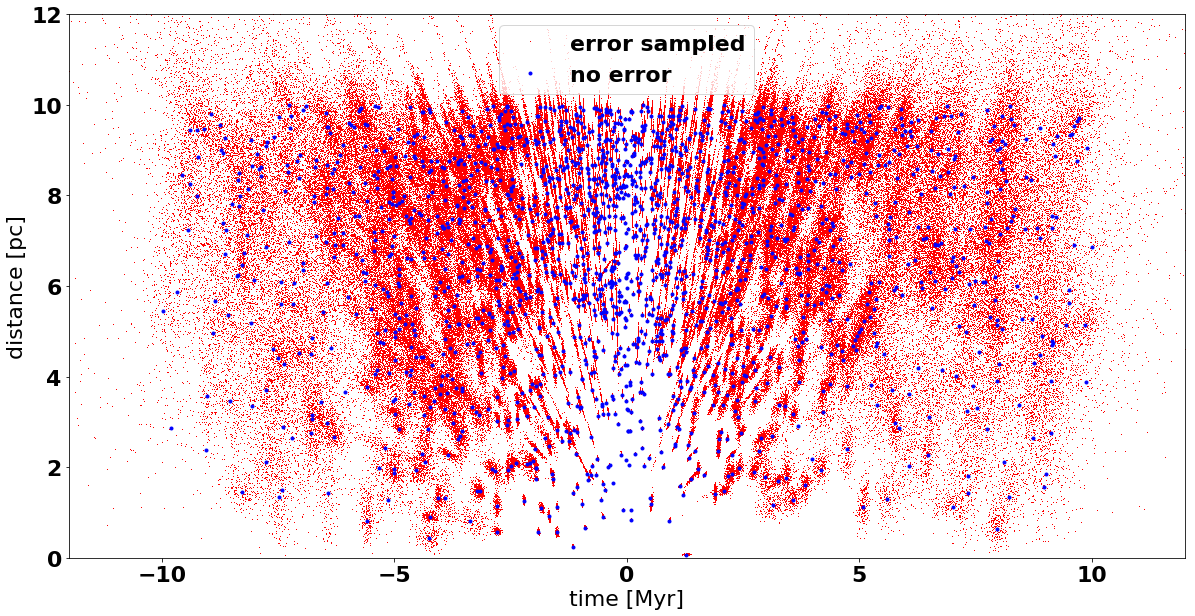

In [13]:
# Now if we sample the error for all encountering stars:

data = x[grvs_cut & astro_cut & time_cut]
min_dist_list = []
min_time_list = []
for i,item in enumerate(data):
    if i%1000==0:
        print(i,len(data))
    parallax,pmra,pmdec,radial_velocity = sample_gaia_uncertainty(item, n_sample = 200)
    min_dist,tot_vel,min_time = linear_motion_approximation_split_input(parallax,pmra,pmdec,radial_velocity)
    min_dist_list.append(min_dist)
    min_time_list.append(min_time)
min_dist = np.hstack(min_dist_list)
min_time = np.hstack(min_time_list)

plt.figure(figsize = (20,10))
plt.plot(min_time,min_dist,'r,',alpha = 1, label = 'error sampled')
plt.plot(data.lma_min_time,data.lma_min_distance,'b.', label = 'no error')
plt.xlim((-12,12))
plt.ylim((0,12))
plt.legend()
plt.ylabel('distance [pc]')
plt.xlabel('time [Myr]')
plt.show()

Now we want to use orbit integration in order to overcome the linear motion approximation.

![MW](https://upload.wikimedia.org/wikipedia/commons/1/12/Artist%27s_impression_of_the_Milky_Way_%28updated_-_annotated%29.jpg)
Credit: NASA/JPL-Caltech/ESO/R. Hurt

Just for your reference the Sun is about 8kpc away from the Galactic center and orbits it with a speed of about 220km/s. It takes about 240Myrs to finish one orbit. 1 km/s ~ 1 pc/Myr.

In [14]:
# initialising the solar Orbit in Galpy works like this:
o = Orbit()
# Then we need to initialise the time grid from 0 to 500Myr in 101 steps:
ts = np.linspace(0,500,101)*u.Myr
# Integrate it over the time
o.integrate(ts,MWPotential2014)
# Animate in different coordinates
o.animate(d1=['x','R'],d2=['y','z'],width=800)

Befor we can start integrating the orbits of all our close encounter stars we need to fine-tune the time steps in order to optimize the integration accuracy and speed.

#### 1: Find out how the computation time needed for orbit integration scales with the number of time-steps
#### Hints:
- You can just use the solar orbit
- Try 11,101 and 1001 steps
- We only want to integrate the orbits from -10 to +10 Myrs
- Galpy can only integrate starting from 0 therefore we have to integrate 2 time, but for now just test in positive direction
- You can test the time that is required for a function call by using: ```%timeit(function())```

In [ ]:
# Speedtest resolution
o = Orbit()
for item in [11,101,1001]:
    print("resolution =", item)
    ts= np.linspace(0,10,item)*u.Myr
    %timeit(o.integrate(ts,MWPotential2014))

#### 2: Try to assess how many time steps one needs in order to be accurate enough over the timespan of 10Myr
#### Hints:
- Use a reference orbit that was produced with a fine grid. Then measure the difference to the same orbit that used a coarser time grid
- Again you can just compare the solar orbit to itself
- You can access e.g. the x coordinate of an orbit after you have integrated it via: ```o.x(ts)```
- Look at the eucledian distance of the two orbits at the latest timestep i.e. 10Myr

In [ ]:
# Accuracy, time steps
o_ref = Orbit()
ts_ref= np.linspace(0,10,10001)*u.Myr
o_ref.integrate(ts_ref,MWPotential2014)
end_time = 10*u.Myr
for item in [11,101,1001,10001]:
    o = Orbit()
    ts= np.linspace(0,10,item)*u.Myr
    o.integrate(ts,MWPotential2014)
    dist = np.sqrt((o.x(end_time)-o_ref.x(end_time))**2+(o.y(end_time)-o_ref.y(end_time))**2+(o.z(end_time)-o_ref.z(end_time))**2)
    print(item,' time steps, dist of position after 10Myr= ',dist)

In [15]:
## Now we can initialise the orbits from our close encounter candidates found with the linear motion approximation
data = x[grvs_cut & astro_cut & time_cut]
t_obs = Time('2015-07-01', scale='utc')
t_cal = Time('2000-01-01', scale='utc')
# Astropy SkyCoord is very useful for coordinate transformation
c= SkyCoord(ra=data.ra*u.deg,dec=data.dec*u.deg,distance=np.divide(1,data.parallax)*u.kpc,
                pm_ra_cosdec=data.pmra*u.mas/u.yr,pm_dec=data.pmdec*u.mas/u.yr,
                radial_velocity=data.radial_velocity*u.km/u.s, obstime = t_obs)
# The epoch can be changed by switching from observed to calculated time.
# Here we switch from Gaia epoch (2015) to J2000, which is the necessary input for Galpy
c = c.apply_space_motion(new_obstime = t_cal)
# This object can be used to initialise the orbit of the stars.

0.01300021881570995 time-steps:  11
0.012714748885213805 time-steps:  101
0.012708462723593644 time-steps:  1001
0.01270835324708459 time-steps:  10001
/home/rybizki/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))



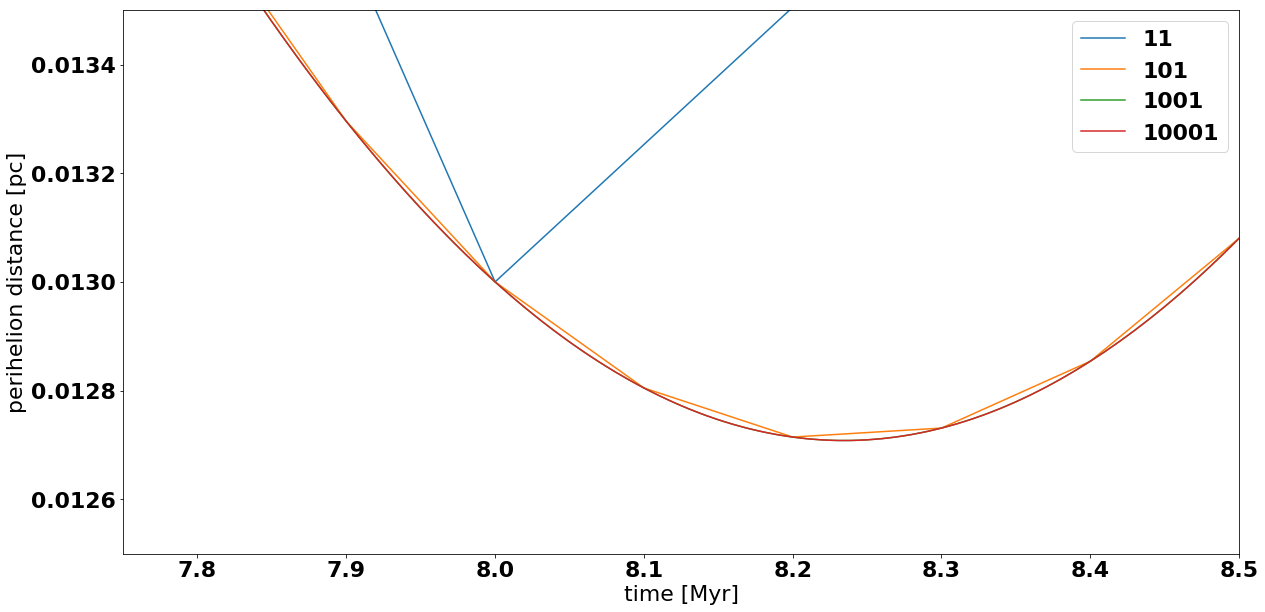

<Figure size 432x288 with 0 Axes>

In [18]:
# We use a bigger font for you to see better on the beamer
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
# Accuracy test minimal distance between the two stars
i = 3 #(a star with closest approach in the future)
plt.figure(figsize= (20,10))
for item in [11,101,1001,10001]:
    o_ref = Orbit()
    ts_ref= np.linspace(0,10,item)*u.Myr
    o_ref.integrate(ts_ref,MWPotential2014)
    # Here we initialize our first star
    o = Orbit(c[i],ro = 8*u.kpc,vo = 220*u.km/u.s, zo = 0.025*u.kpc, solarmotion = [-11.1,12.24,7.25])
    o.integrate(ts_ref,MWPotential2014)
    dist = np.sqrt((o.x(ts_ref)-o_ref.x(ts_ref))**2+(o.y(ts_ref)-o_ref.y(ts_ref))**2+(o.z(ts_ref)-o_ref.z(ts_ref))**2)
    plt.plot(ts_ref,dist, label=(item))
    print(min(dist), 'time-steps: ',item)
# Just a zoom on the closest encounter
plt.xlim((7.75,8.5))
plt.ylim((0.0125,0.0135))
plt.xlabel('time [Myr]')
plt.ylabel('perihelion distance [pc]')
plt.legend()
plt.show()
plt.clf()

/home/rybizki/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not used by contour: 'aspect'
  s)

/home/rybizki/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))



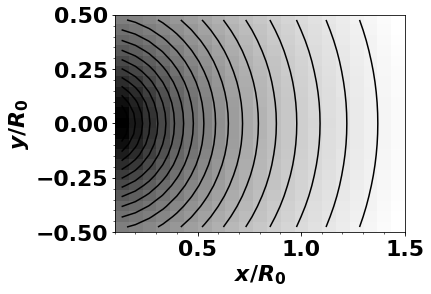

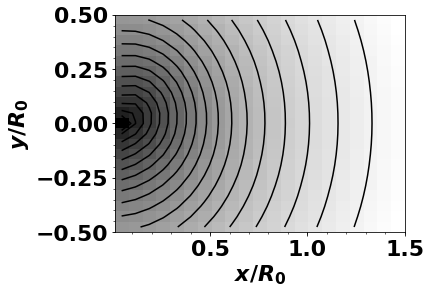

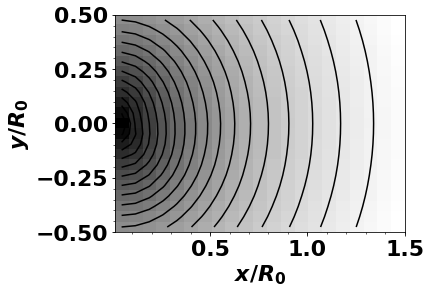

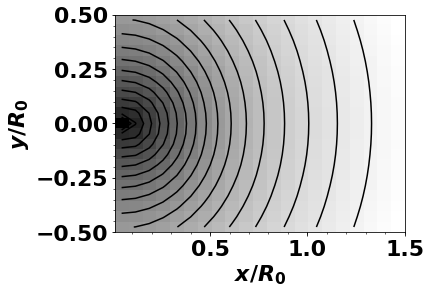

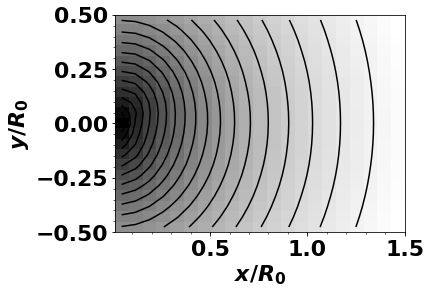

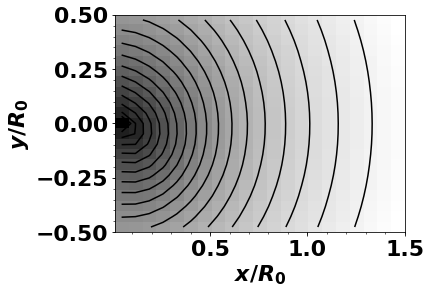

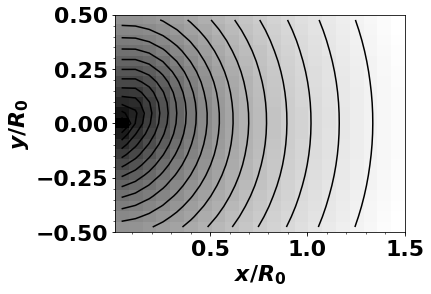

In [19]:
# Plot potentials and use possible alternative potential which includes a bar. 
# might be useful to assess uncertainties due to the Galactic potential model used.
plotPotentials(MWPotential2014,rmin=0.1, xy = True)
pot_with_bar = [MWPotential2014,DehnenBarPotential()]
for t in np.array([0,25,50,75,100,125])*u.Myr:
    plotPotentials(pot_with_bar, rmin=0.01, phi = 0,t=t, xy = True)

/home/rybizki/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))



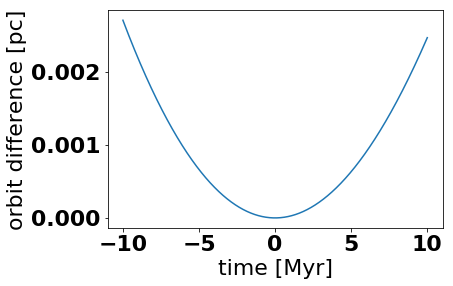

<Figure size 432x288 with 0 Axes>

In [20]:
# Here we integrate two orbits of the sun, one in the MWPotential2014 and one that includes the rotating bar.
# The differences over 10 Myr can be seen in the plot that follows
ts = np.linspace(0,10,101)*u.Myr
ts_fine= np.linspace(0,10,10001)*u.Myr
ts_all = np.hstack((-ts_fine[::-1][:-1].value,ts_fine.value))*u.Myr
osunf = Orbit()
osunp = Orbit()
osunf.integrate(ts,pot_with_bar)
osunp.integrate(-ts,pot_with_bar)
of= Orbit()
dist = orbit_distance(osunf,of,ts,ts_fine, MWPotential2014)
op= Orbit()
dist_neg = orbit_distance(osunp,op,-ts,-ts_fine,MWPotential2014)
dist = np.hstack((dist_neg[::-1][:-1],dist))
plt.plot(ts_all,dist)
plt.xlabel('time [Myr]')
plt.ylabel('orbit difference [pc]')
plt.show()
plt.clf() 

/home/rybizki/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))



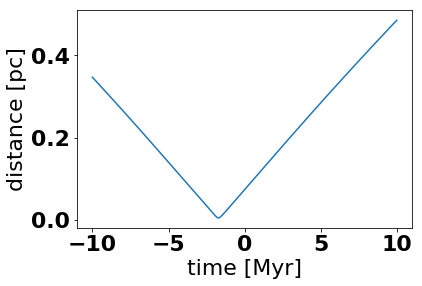

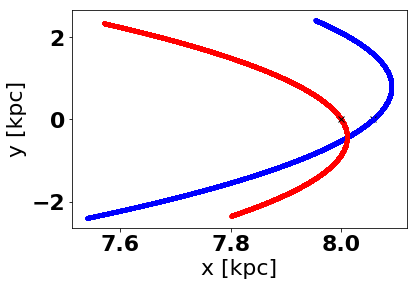

0 distance orbit vs lma in pc: 5.095, 4.901 encounter time in Myr orbit vs lma: -1.717, -1.720


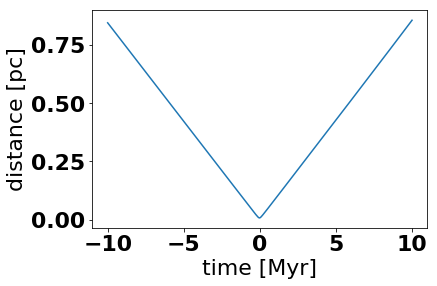

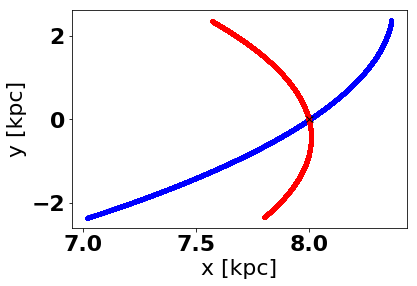

1 distance orbit vs lma in pc: 6.893, 6.893 encounter time in Myr orbit vs lma: -0.026, -0.026


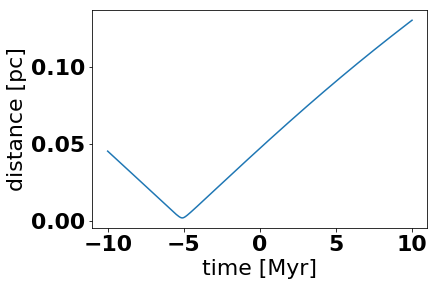

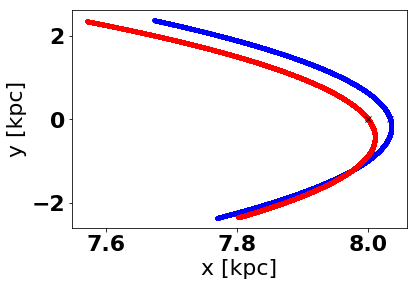

2 distance orbit vs lma in pc: 1.796, 2.413 encounter time in Myr orbit vs lma: -5.101, -5.197


<Figure size 432x288 with 0 Axes>

In [21]:
ts = np.linspace(0,10,101)*u.Myr
ts_fine= np.linspace(0,10,10001)*u.Myr
ts_all = np.hstack((-ts_fine[::-1][:-1].value,ts_fine.value))*u.Myr
osunf = Orbit() # Sun is loaded
osunp = Orbit()
osunf.integrate(ts,MWPotential2014)
osunp.integrate(-ts,MWPotential2014)
for i in range(3):
    of= Orbit(c[i],ro = 8*u.kpc,vo = 220*u.km/u.s, zo = 0.025*u.kpc, solarmotion = [-11.1,12.24,7.25])
    dist = orbit_distance(osunf,of,ts,ts_fine,MWPotential2014)
    op= Orbit(c[i],ro = 8*u.kpc,vo = 220*u.km/u.s, zo = 0.025*u.kpc, solarmotion = [-11.1,12.24,7.25])
    dist_neg = orbit_distance(osunp,op,-ts,-ts_fine,MWPotential2014)
    dist = np.hstack((dist_neg[::-1][:-1],dist))
    #print(dist)
    plt.plot(ts_all,dist)
    plt.xlabel('time [Myr]')
    plt.ylabel('distance [pc]')
    plt.show()
    plt.clf() 
    plt.plot(of.x(ts_fine),of.y(ts_fine),'.b')
    plt.plot(of.x(ts[0]),of.y(ts[0]),'kx')
    plt.plot(op.x(-ts_fine),op.y(-ts_fine),'.b')
    plt.plot(osunf.x(ts_fine),osunf.y(ts_fine),'.r')
    plt.plot(osunp.x(-ts_fine),osunp.y(-ts_fine),'.r')
    plt.plot(osunf.x(ts[0]),osunf.y(ts[0]),'kx')
    plt.xlabel('x [kpc]')
    plt.ylabel('y [kpc]')
    plt.show()
    plt.clf()
    print(i,'distance orbit vs lma in pc: %.3f, %.3f' %(min(dist)*1000,data[i].lma_min_distance),
          'encounter time in Myr orbit vs lma: %.3f, %.3f' %(ts_all[np.where(dist==min(dist))[0][0]].value,data[i].lma_min_time))

In [22]:
# Integrating all the orbits
'''
# Take the time
start = time.time()
# Create a grid for integration
ts = np.linspace(0,10,101)*u.Myr
# Create finer grid for interpolation
ts_fine= np.linspace(0,10,10001)*u.Myr
# stack the negative and positive times together
ts_all = np.hstack((-ts_fine[::-1][:-1].value,ts_fine.value))*u.Myr
# Load and integrate the past and the future sun
osunf = Orbit() # Sun is loaded
osunp = Orbit()
osunf.integrate(ts,MWPotential2014)
osunp.integrate(-ts,MWPotential2014)
# For each star in our sample:
for i in range(len(c)):
    # Integrate its orbit in the past and in the future
    of= Orbit(c[i],ro = 8*u.kpc,vo = 220*u.km/u.s, zo = 0.025*u.kpc, solarmotion = [-11.1,12.24,7.25])
    # And calculate the distance of each timestep point with the respective time step point of the sun 
    dist = orbit_distance(osunf,of,ts,ts_fine,MWPotential2014)
    op= Orbit(c[i],ro = 8*u.kpc,vo = 220*u.km/u.s, zo = 0.025*u.kpc, solarmotion = [-11.1,12.24,7.25])
    dist_neg = orbit_distance(osunp,op,-ts,-ts_fine,MWPotential2014)
    # stack the distances corresponding to future and past
    dist = np.hstack((dist_neg[::-1][:-1],dist))
    # get the minimum distance in pc
    min_dist = min(dist)*1000
    # save the corresponding timestep
    min_time = ts_all[np.where(dist==min(dist))[0][0]].value
    # write those values into the array 
    data[i].orbit_min_distance = min_dist
    data[i].orbit_min_time = min_time
    # print the comparison to the lma values
    print(i,len(c),'distance orbit vs lma in pc: %.4f, %.4f' %(min_dist,data[i].lma_min_distance),
          'encounter time in Myr orbit vs lma: %.4f, %.4f' %(min_time,data[i].lma_min_time))
end = time.time()
print('calc time in s: ', end-start)
# Safe the data in order to only integrate once
np.save('../data/temp/data.npy',data)
'''

"\n# Take the time\nstart = time.time()\n# Create a grid for integration\nts = np.linspace(0,10,101)*u.Myr\n# Create finer grid for interpolation\nts_fine= np.linspace(0,10,10001)*u.Myr\n# stack the negative and positive times together\nts_all = np.hstack((-ts_fine[::-1][:-1].value,ts_fine.value))*u.Myr\n# Load and integrate the past and the future sun\nosunf = Orbit() # Sun is loaded\nosunp = Orbit()\nosunf.integrate(ts,MWPotential2014)\nosunp.integrate(-ts,MWPotential2014)\n# For each star in our sample:\nfor i in range(len(c)):\n    # Integrate its orbit in the past and in the future\n    of= Orbit(c[i],ro = 8*u.kpc,vo = 220*u.km/u.s, zo = 0.025*u.kpc, solarmotion = [-11.1,12.24,7.25])\n    # And calculate the distance of each timestep point with the respective time step point of the sun \n    dist = orbit_distance(osunf,of,ts,ts_fine,MWPotential2014)\n    op= Orbit(c[i],ro = 8*u.kpc,vo = 220*u.km/u.s, zo = 0.025*u.kpc, solarmotion = [-11.1,12.24,7.25])\n    dist_neg = orbit_distanc

In [23]:
data = np.load('../data/temp/data.npy')
data= data.view(np.recarray)
data.orbit_min_distance

array([5.0945419 , 6.89253551, 1.79595114, ..., 1.44022845, 4.36887542,
       8.0326577 ])

/home/rybizki/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))



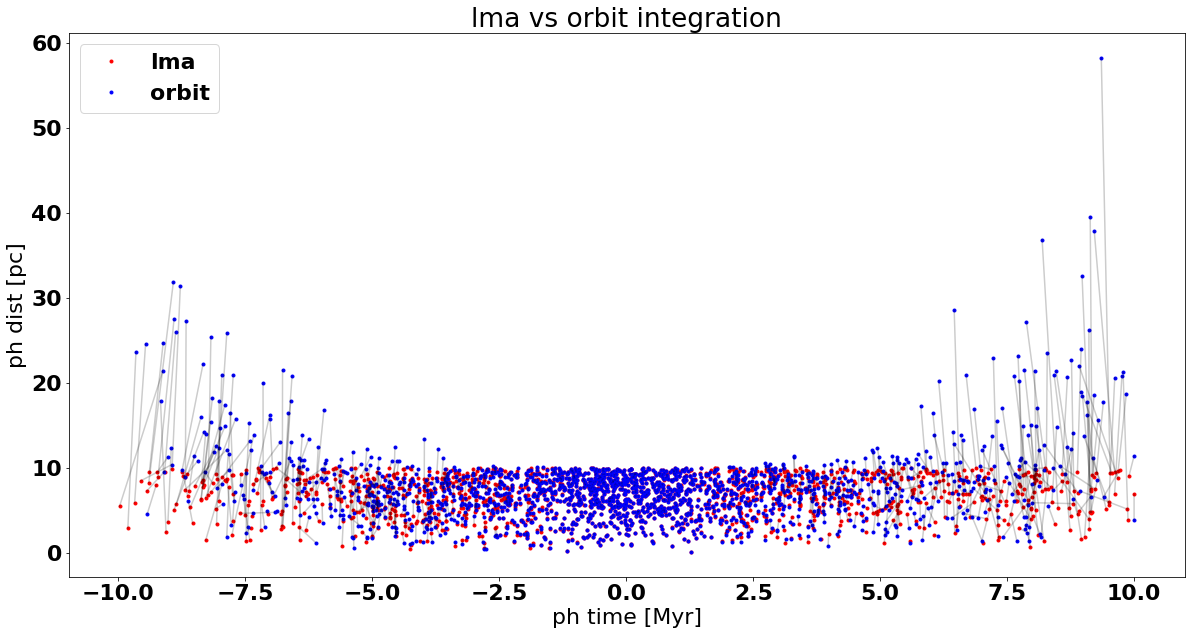

<Figure size 432x288 with 0 Axes>

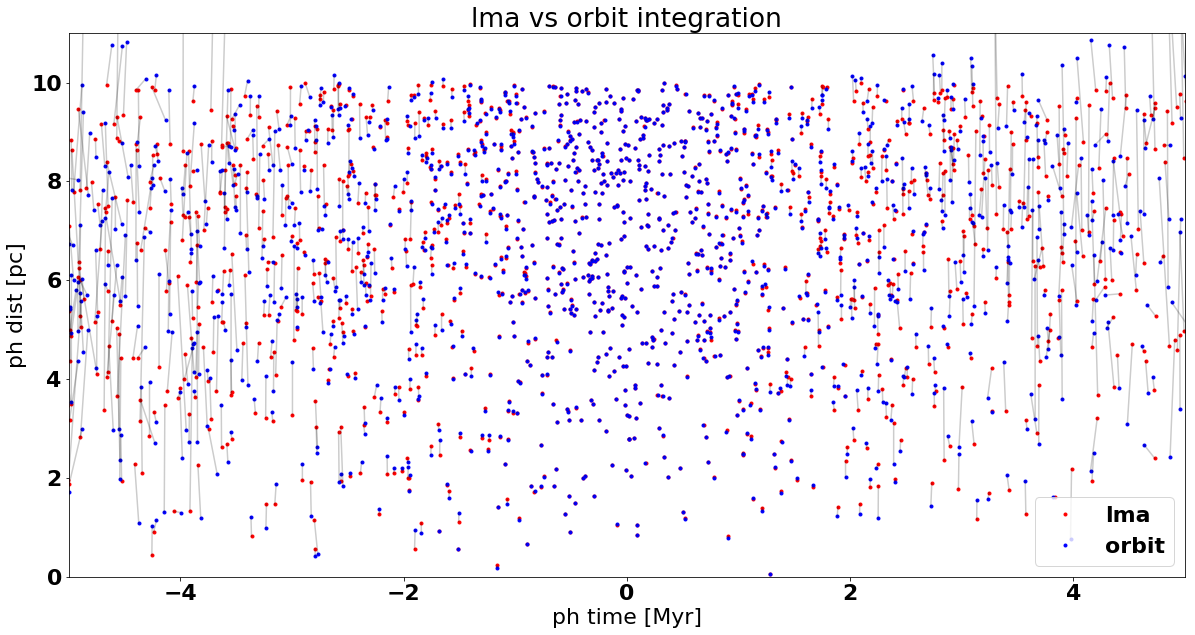

<Figure size 432x288 with 0 Axes>

In [24]:
data = np.load('../data/temp/data.npy')
data = data.view(np.recarray)
plot_lma_vs_orbit(data)
plot_lma_vs_orbit(data,(-5,5),(0,11))

In [25]:
#Gliese710 should still be the closest encounter, the min distance slightly changed though
cut = np.where(data.orbit_min_distance == min(data.orbit_min_distance))
print('source_id: ',data.source_id[cut], ' min distance: ',min(data.orbit_min_distance), 'min distance lma: ', min(data.lma_min_distance)) 

source_id:  [4270814637616488064]  min distance:  0.05299243063795243 min distance lma:  0.05445161878999502


#### Redo the error sampling for Gliese710 but this time integrate its orbit and see what the distribution of perihelion distances and times is.
#### Hints:
- Variant(a, including correlation, is more demanding): Use the ```sample_gaia_uncertainty``` routine which produces correlated errors for parallax, pmra, pmdec and try to extend this to include ra and dec
- Variant(b, without correlation): just sample the error of ra, dec, parallax, pmra, pmdec and radial velocity independently
- Both variants: Sample the error ~500 times and use the SkyCoord example shown above to initialise the orbits
- integrate the orbits as above and save the closest encounter distance and time
- look at the distribution of perihelion distances and times and give summary statistics (e.g. percentiles)

In [26]:
############################################################################### step 1 Variant (b)
ra, dec, parallax, pmra, pmdec, radial_velocity = sample_gaia_uncertainty_5d(data[cut[0][0]], n_sample=100)#, no_correlation=True)
############################################################################### step 2
c= SkyCoord(ra=ra*u.deg,dec=dec*u.deg,distance=np.divide(1,parallax)*u.kpc,
                pm_ra_cosdec=pmra*u.mas/u.yr,pm_dec=pmdec*u.mas/u.yr,
                radial_velocity=radial_velocity*u.km/u.s, obstime = t_obs)
# The epoch can be changed by switching from observed to calculated time.
# Here we switch from Gaia epoch (2015) to J2000, which is the necessary input for Galpy
c = c.apply_space_motion(new_obstime = t_cal)
############################################################################### step 3
start = time.time()
# Create a grid for integration
ts = np.linspace(0,10,101)*u.Myr
# Create finer grid for interpolation
ts_fine= np.linspace(0,10,10001)*u.Myr
# stack the negative and positive times together
ts_all = np.hstack((-ts_fine[::-1][:-1].value,ts_fine.value))*u.Myr
# Load and integrate the past and the future sun
osunf = Orbit() # Sun is loaded
osunp = Orbit()
osunf.integrate(ts,MWPotential2014)
osunp.integrate(-ts,MWPotential2014)
# For each star in our sample:
ph_time = np.zeros(len(c))
ph_dist = np.zeros(len(c))
for i in range(len(c)):
    if i%100==0:
        print(i,len(c))
    # Integrate its orbit in the past and in the future
    of= Orbit(c[i],ro = 8*u.kpc,vo = 220*u.km/u.s, zo = 0.025*u.kpc, solarmotion = [-11.1,12.24,7.25])
    # And calculate the distance of each timestep point with the respective time step point of the sun 
    dist = orbit_distance(osunf,of,ts,ts_fine,MWPotential2014)
    op= Orbit(c[i],ro = 8*u.kpc,vo = 220*u.km/u.s, zo = 0.025*u.kpc, solarmotion = [-11.1,12.24,7.25])
    dist_neg = orbit_distance(osunp,op,-ts,-ts_fine,MWPotential2014)
    # stack the distances corresponding to future and past
    dist = np.hstack((dist_neg[::-1][:-1],dist))
    # get the minimum distance in pc
    min_dist = min(dist)*1000
    # save the corresponding timestep
    min_time = ts_all[np.where(dist==min(dist))[0][0]].value
    # write those values into the array 
    ph_dist[i] = min_dist
    ph_time[i] = min_time
    # print the comparison to the lma values
end = time.time()
print('calc time in s: ', end-start)
# Safe the data in order to only integrate once
np.save('../data/temp/gliese_dist_cov.npy',ph_dist)
np.save('../data/temp/gliese_time_cov.npy',ph_time)
#np.save('../data/temp/gliese_dist_no_cov.npy',ph_dist)
#np.save('../data/temp/gliese_time_no_cov.npy',ph_time)

0 100
calc time in s:  26.69628119468689


time 5 1.2109
time 50 1.28
time 95 1.3413499999999998
distance 5 0.0379325496698555
distance 50 0.0540139063757074
distance 95 0.07102551068265382
/home/rybizki/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))



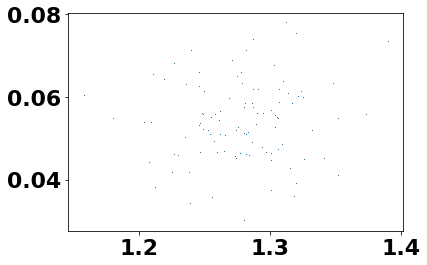

In [27]:
ph_dist = np.load('../data/temp/gliese_dist_cov.npy')
ph_time = np.load('../data/temp/gliese_time_cov.npy')

plt.plot(ph_time,ph_dist,',')
for item_name,item in zip(['time','distance'],[ph_time,ph_dist]):
    for percentile in [5,50,95]:
        print(item_name,percentile,np.percentile(item,percentile))
##### With correlation
#time 5 1.2179499999999999
#time 50 1.284
#time 95 1.3490499999999999
#distance 5 0.03876350849624189
#distance 50 0.053033183575860204
#distance 95 0.06855506916335634
##### Without correlation
#time 5 1.225
#time 50 1.28
#time 95 1.3421
#distance 5 0.03758774406853487
#distance 50 0.053446748605482305
#distance 95 0.06975689230327281

In [28]:
data = y[cut_grvs_mock & cut_teff & time_cut_mock]

print(len(data))
t_obs = Time('2015-07-01', scale='utc')
t_cal = Time('2000-01-01', scale='utc')
c= SkyCoord(ra=data.ra*u.deg,dec=data.dec*u.deg,distance=np.divide(1,data.parallax)*u.kpc,
                pm_ra_cosdec=data.pmra*u.mas/u.yr,pm_dec=data.pmdec*u.mas/u.yr,
                radial_velocity=data.radial_velocity*u.km/u.s, obstime = t_obs)
c = c.apply_space_motion(new_obstime = t_cal)

2694


In [29]:
'''
start = time.time()
ts = np.linspace(0,10,101)*u.Myr
ts_fine= np.linspace(0,10,10001)*u.Myr
ts_all = np.hstack((-ts_fine[::-1][:-1].value,ts_fine.value))*u.Myr
osunf = Orbit() # Sun is loaded
osunp = Orbit()
osunf.integrate(ts,MWPotential2014)
osunp.integrate(-ts,MWPotential2014)
for i in range(len(c)):
    of= Orbit(c[i],ro = 8*u.kpc,vo = 220*u.km/u.s, zo = 0.025*u.kpc, solarmotion = [-11.1,12.24,7.25])
    dist = orbit_distance(osunf,of,ts,ts_fine,MWPotential2014)
    op= Orbit(c[i],ro = 8*u.kpc,vo = 220*u.km/u.s, zo = 0.025*u.kpc, solarmotion = [-11.1,12.24,7.25])
    dist_neg = orbit_distance(osunp,op,-ts,-ts_fine,MWPotential2014)
    dist = np.hstack((dist_neg[::-1][:-1],dist))
    min_dist = min(dist)*1000
    min_time = ts_all[np.where(dist==min(dist))[0][0]].value
    data[i].orbit_min_distance = min_dist
    data[i].orbit_min_time = min_time
    print(i,len(c),'distance orbit vs lma in pc: %.4f, %.4f' %(min_dist,data[i].lma_min_distance),
          'encounter time in Myr orbit vs lma: %.4f, %.4f' %(min_time,data[i].lma_min_time))
end = time.time()
print('calc time in s: ', end-start)
np.save('../data/temp/mock_data.npy',data)
'''

"\nstart = time.time()\nts = np.linspace(0,10,101)*u.Myr\nts_fine= np.linspace(0,10,10001)*u.Myr\nts_all = np.hstack((-ts_fine[::-1][:-1].value,ts_fine.value))*u.Myr\nosunf = Orbit() # Sun is loaded\nosunp = Orbit()\nosunf.integrate(ts,MWPotential2014)\nosunp.integrate(-ts,MWPotential2014)\nfor i in range(len(c)):\n    of= Orbit(c[i],ro = 8*u.kpc,vo = 220*u.km/u.s, zo = 0.025*u.kpc, solarmotion = [-11.1,12.24,7.25])\n    dist = orbit_distance(osunf,of,ts,ts_fine,MWPotential2014)\n    op= Orbit(c[i],ro = 8*u.kpc,vo = 220*u.km/u.s, zo = 0.025*u.kpc, solarmotion = [-11.1,12.24,7.25])\n    dist_neg = orbit_distance(osunp,op,-ts,-ts_fine,MWPotential2014)\n    dist = np.hstack((dist_neg[::-1][:-1],dist))\n    min_dist = min(dist)*1000\n    min_time = ts_all[np.where(dist==min(dist))[0][0]].value\n    data[i].orbit_min_distance = min_dist\n    data[i].orbit_min_time = min_time\n    print(i,len(c),'distance orbit vs lma in pc: %.4f, %.4f' %(min_dist,data[i].lma_min_distance),\n          'encou

/home/rybizki/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))



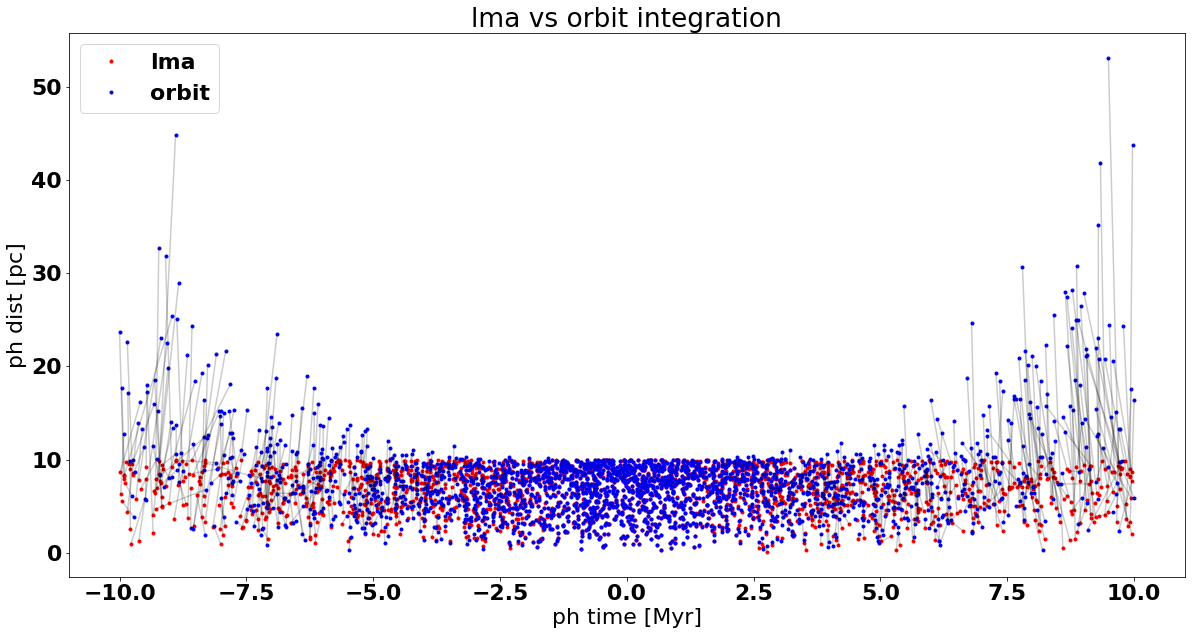

<Figure size 432x288 with 0 Axes>

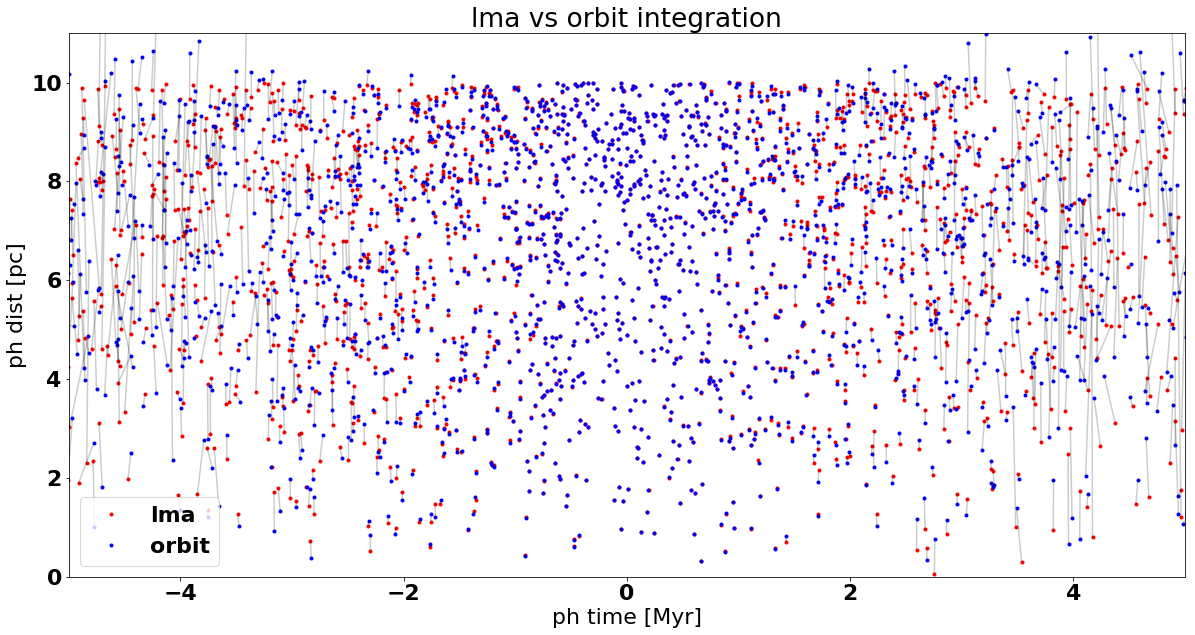

<Figure size 432x288 with 0 Axes>

In [30]:
data = np.load('../data/temp/mock_data.npy')
data = data.view(np.recarray)
plot_lma_vs_orbit(data)
plot_lma_vs_orbit(data,(-5,5),(0,11))

In [31]:
data = np.load('../data/temp/data.npy')
data = data.view(np.recarray)
mock = np.load('../data/temp/mock_data.npy')

/home/rybizki/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))



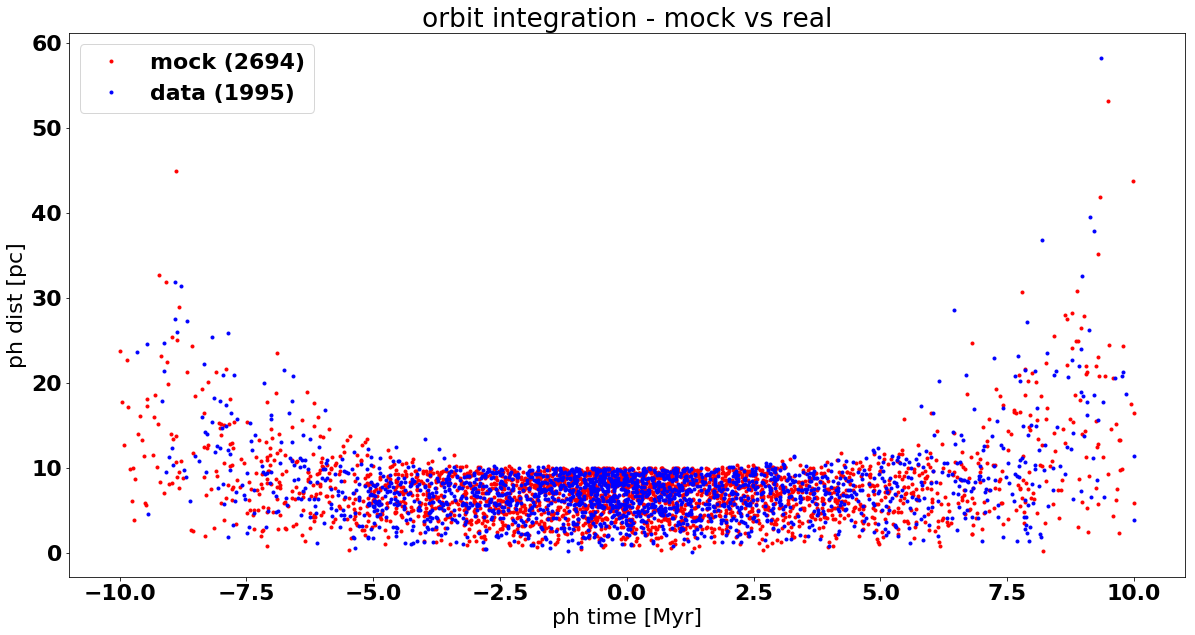

<Figure size 432x288 with 0 Axes>

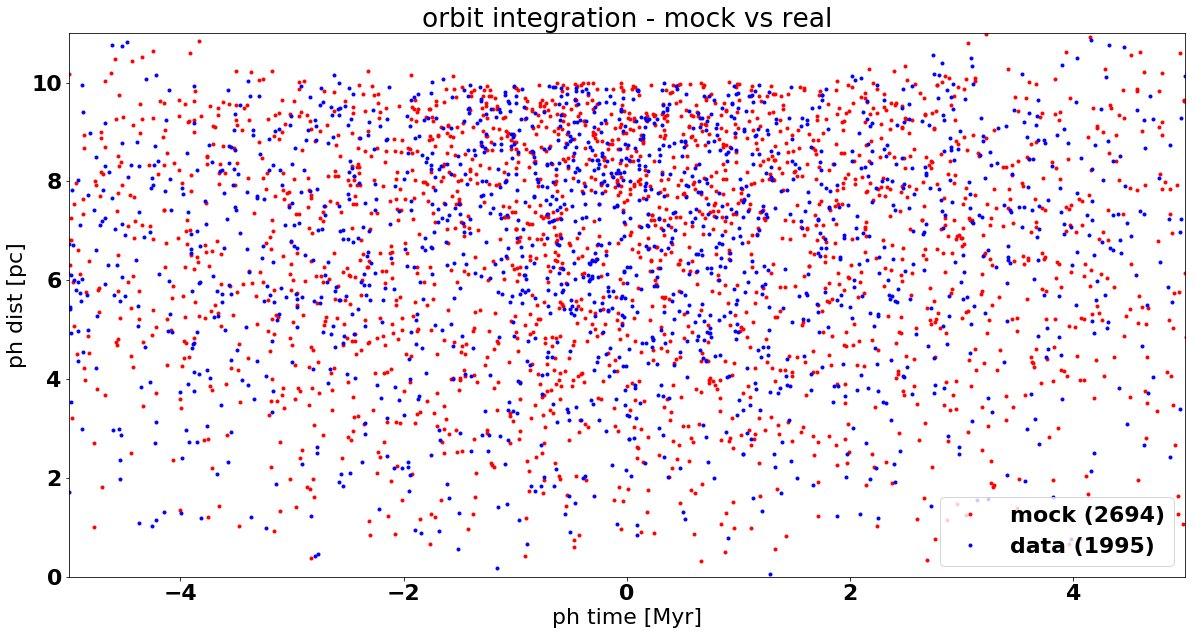

<Figure size 432x288 with 0 Axes>

In [32]:
# Compare the mock orbits vs the real orbit perihelion distances

plot_comparison_orbit(data,mock)
plot_comparison_orbit(data,mock,(-5,5),(0,11))

In [33]:
# Assessment of missing targets due to lma selection
# I downloaded a complete sample of GDR2mock stars up to 12th G_RVS and with 3550 < teff < 6900
# Which totals to 6.8mio. I calculated the lma and integrated the orbit for each one of those on our cluster
mock = np.load('../data/day_3/karun_all_mock_result/all_results.npy')
mock = mock.view(np.recarray)
print(len(mock))

# Discussion: How could we check how many stars we are loosing because of LMA?

6803437


/home/rybizki/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))



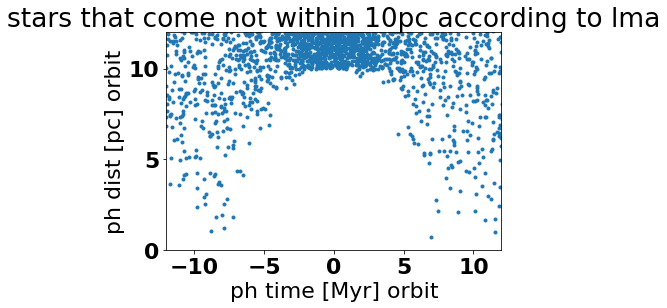

<Figure size 432x288 with 0 Axes>

In [34]:
# Now we can only chose stars that are further away than 10 pc according to LMA
cut = (mock.lma_min_distance >=10)
# And check how close they actually come
plt.plot(mock.orbit_min_time[cut],mock.orbit_min_distance[cut],'.')
plt.xlim((-12,12))
plt.ylim((0,12))
plt.title('stars that come not within 10pc according to lma')
plt.ylabel('ph dist [pc] orbit')
plt.xlabel('ph time [Myr] orbit')
plt.show()
plt.clf()

### Completeness Analysis
#### Hom many close encounters are we missing?
As we have seen just above we can consider our sample of encounters (that was cut to have 10pc perhihelion in LMA) complete within a window of time [-5,5] and dist [0,5].
To get a rough idea of how many encounters we miss we will consider the complete GDR2mock catalogue to represent the real universe (we are only missing very few faint and fast stars, that are even fainter than 20.7 at the moment).
Then we apply the grvs cut and the teff cut to that sample and compare the ratio. Then we know approximately how many encounters we are missing

39841
3391
/home/rybizki/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))



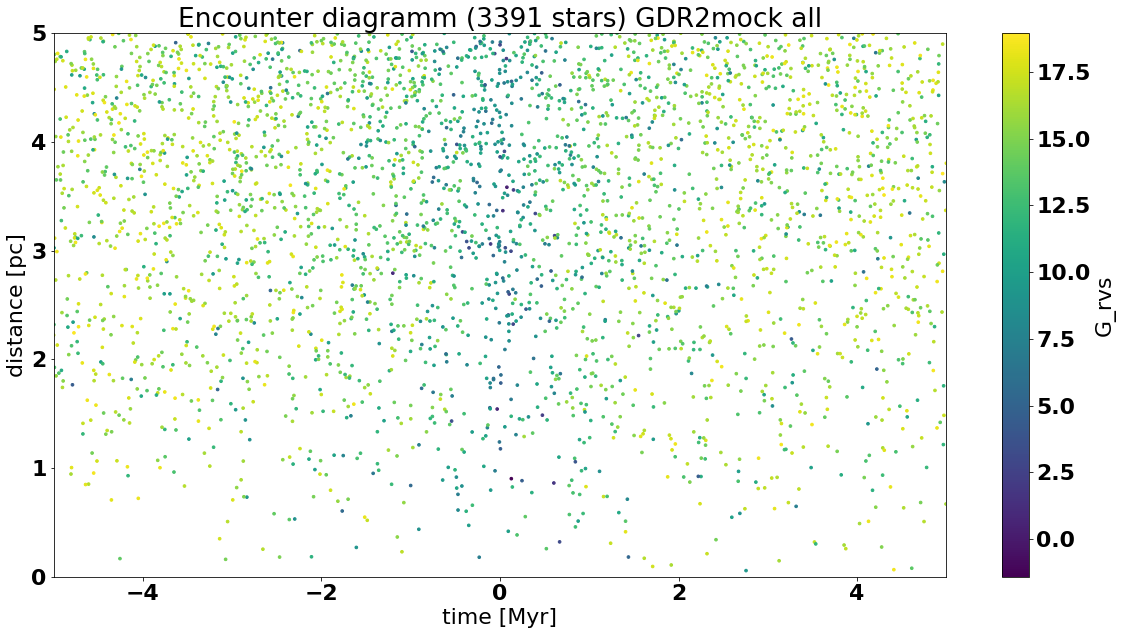

In [47]:
mock = np.copy(y)
# That can be assumed to be almost the entire sample (we are missing a few faint and fast sources)
mock = mock.view(np.recarray)
time_dist_cut = (np.abs(mock.lma_min_time) < 5) & (mock.lma_min_distance < 5)
print(len(mock))
mock = mock[time_dist_cut]
print(len(mock))
plot_encounter(mock, 'GDR2mock all', mock.phot_rvs_mean_mag, 'G_rvs',(-5,5),(0,5))

3129
540
/home/rybizki/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))



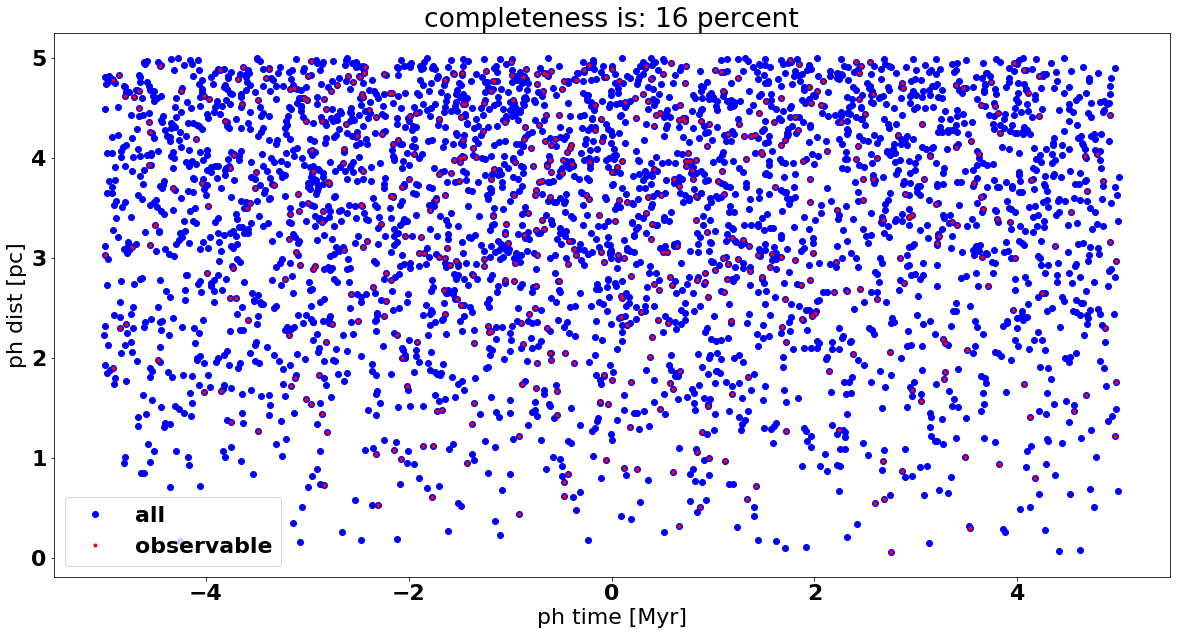

<Figure size 432x288 with 0 Axes>

In [49]:
# That can be assumed to be the sample that we are able to determine perihelia for because of gaia's RVS mag limit
# In essence this is the selection function of GaiaDR2 radial_velocity determinations
mock_grvs_teff = y[cut_grvs_mock & cut_teff]
print(len(mock_grvs_teff))
mock_grvs_teff = y[cut_grvs_mock & cut_teff & time_dist_cut]
print(len(mock_grvs_teff))

plt.figure(figsize=(20,10))
plt.plot(mock.lma_min_time,mock.lma_min_distance,'.b',ms = 12, label = 'all')
plt.plot(mock_grvs_teff.lma_min_time,mock_grvs_teff.lma_min_distance,'.r', label = 'observable')
plt.legend()
plt.ylabel('ph dist [pc]')
plt.xlabel('ph time [Myr]')
plt.title('completeness within this window is: %.0f percent' %(100* len(mock_grvs_teff)/len(mock)))
plt.show()
plt.clf()

Those 16% are probably a quite good estimate. But we should always be aware of the assumptions that went into this estimate:
- We use lma perihelia instead of orbit integrated.
- We miss a few faint and fast stars that did not enter GDR2mock because they are too faint for the magnitude limit
- There is poisson noise in the realisation of the simulation
- Its a simulated and not the real universe
- There are no white dwarfs simulated...

# Follow up observations
#### Which are useful targets for follow up observations
- GaiaDR2 provides only radial_velocities for 7.2 mio stars.
- GaiaDR3 will do that for many more stars up to 14th G_rvs magnitude
- Still we have ra, dec, parallax, pmra, pmdex for all the other stars, which helps us to assess the likelihood of close encounters
- We will query likely encounter candidates without radial_velocity measurement
- We query a similar set of stars from GDR2mock, where we know the radial velocities
- We use the mock data as a prior for the real data.
#### The ADQL queries:
- GDR2, basically the star comes closer than 10pc under lma assuming that the radial velocity is about 300km/s
- also G needs to be smaller than 17th (the follow up spectrograph needs good integration time, a faint star might take too long to get a good spectra).

```SQL
SELECT * FROM gaiadr2.gaia_source
Where (parallax IS NOT NULL) AND (parallax > -0.029)
AND (radial_velocity IS NULL) AND
((( 1000*4.74047*sqrt(power(pmra,2)+power(pmdec,2))/ power(parallax+0.029,2))
/ sqrt( (power(pmra,2)+power(pmdec,2))
* power(4.74047/(parallax+0.029),2)
+ power(300,2))) < 10) AND phot_g_mean_mag < 17
```

- For GDR2mock we do basically the same query, except only looking for ```source_id``` and ```radial_velocity``` and replacing ```"radial_velocity IS NULL"``` with ```"phot_rvs_mean_mag > 12"```.

In [61]:
# Loading the data sets. Check out the exact query on the data retrieval notebook
fol = np.load('../data/day_3/gdr2_lma_cds_wo_rv_10/result.npy')
prior = np.load('../data/day_3/gdr2mock_prior_rvs_follow_up_10/result.npy')
prior = prior.view(np.recarray)
fol = fol.view(np.recarray)

In [62]:
# Inspect the files
print(len(prior),prior.dtype.names)
print(len(fol),fol.dtype.names)

920353 ('radial_velocity', 'source_id')
1230410 ('designation', 'ra', 'ra_error', 'dec', 'dec_error', 'solution_id', 'source_id', 'random_index', 'ref_epoch', 'parallax', 'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_n_obs_al', 'astrometric_n_obs_ac', 'astrometric_n_good_obs_al', 'astrometric_n_bad_obs_al', 'astrometric_gof_al', 'astrometric_chi2_al', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'astrometric_params_solved', 'astrometric_primary_flag', 'astrometric_weight_al', 'astrometric_pseudo_colour', 'astrometric_pseudo_colour_error', 'mean_varpi_factor_al', 'astrometric_matched_observations', 'visibility_periods_used', 'astrometric_sigma5d_max', 'frame_rotator_object_type', 'matched_observations', 'duplicated_source', 'phot_g_n_

/home/rybizki/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))



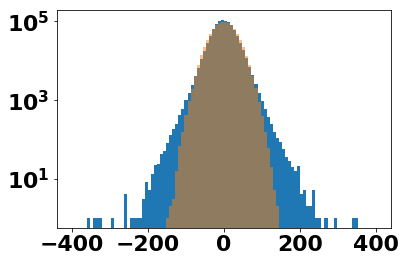

In [63]:
# What is the distribution of velocities? Is it Gaussian?
sim_gauss = np.random.normal(loc = np.mean(prior.radial_velocity), scale = np.std(prior.radial_velocity), size = len(prior.radial_velocity))
plt.hist(prior.radial_velocity,bins = 100, range=(-400,400))
plt.hist(sim_gauss, bins = 100, range=(-400,400), alpha = 0.5)
plt.yscale('log')

/home/rybizki/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))



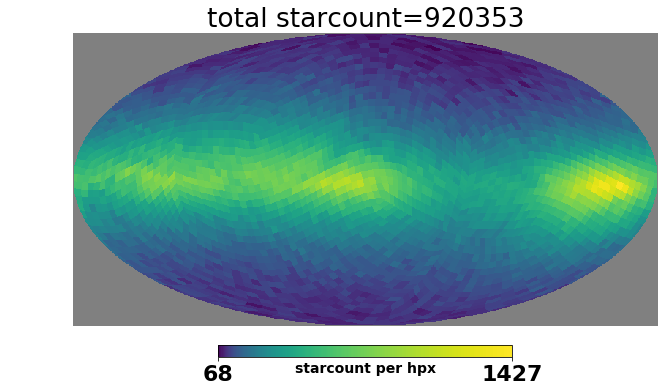

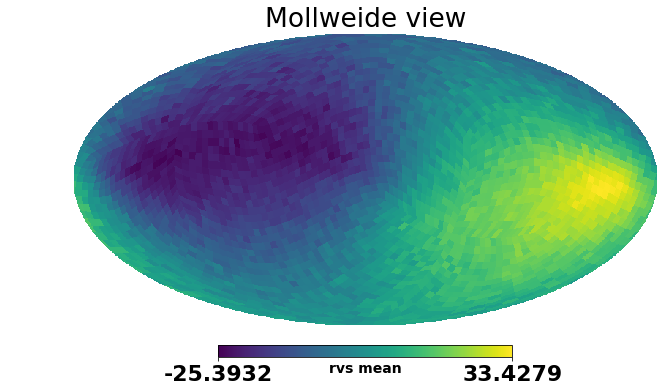

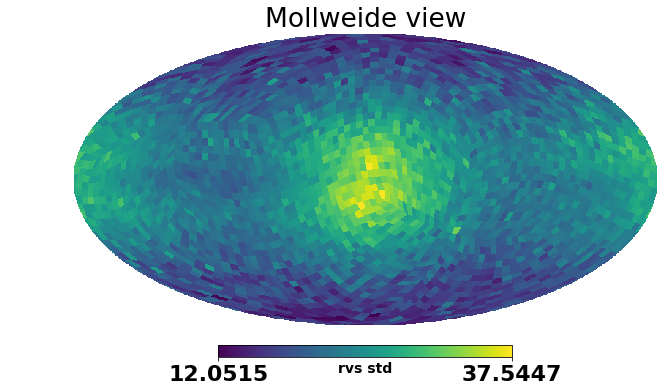

In [64]:
## Plot rvs per healpix
plot_mollweide_log(hpx_density(prior.source_id,4))
mean,std = hpx_statistic(prior.source_id,prior.radial_velocity,4)
# The whole sky has ~41k deg^2
# Healpix number of 6 ~ 49152 equal sized tiles ~ 0.8 deg^2 per healpix, for healpix number 4 its 4^2 times bigger
hp.mollview(mean, cbar = True, nest = True, coord= "CG", unit = 'rvs mean',notext =True)
plt.show()
hp.mollview(std, cbar = True, nest = True, coord= "CG", unit = 'rvs std',notext =True)
plt.show()

We need to chose the magnitude range of our targets wisely:

![Completeness](pics/completeness.png)

In [65]:
# Chose follow up targets in specific mag range and make quality cut
# cut GRVS 14-17
grvs=np.zeros(len(fol))
gmrp = fol.phot_g_mean_mag - fol.phot_rp_mean_mag
blue_cut = (gmrp<1.4) 
grvs[blue_cut] = grvs_for_blue_sources(fol.phot_g_mean_mag[blue_cut],fol.phot_rp_mean_mag[blue_cut])
red_cut = (gmrp>=1.4) 
grvs[red_cut] = grvs_for_red_sources(fol.phot_g_mean_mag[red_cut],fol.phot_rp_mean_mag[red_cut])
# cut for GRVS
grvs_cut = (grvs<=15) & (grvs>14)
print(len(fol))
fol=fol[grvs_cut]
print(len(fol))

# Also exclude likely spurious sources
ru = compute_ruwe(fol)
# apply the cut and look at the result
astro_cut = (ru<1.4)
fol = fol[astro_cut]
print(len(fol))

/home/rybizki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """

/home/rybizki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater_equal
  import sys

1230410
416897
287583


In [66]:
start = time.time()
hpx_level = 4

# Preparation of the prior
source_id_factor = gaia_hpx_factor(hpx_level)
n_hpx = np.floor_divide(prior.source_id,source_id_factor)
sort = np.argsort(n_hpx)
# Matching healpix number to rvs
n_hpx = n_hpx[sort]
rvs = prior.radial_velocity[sort]
# Creating an index that maps healpix numbers to all rvs measurements in that healpix number
index = np.searchsorted(n_hpx,np.arange(number_of_healpixels(hpx_level)))
index = np.hstack((index,len(rvs)))
n_sample = 101
sampled_perihelia = np.zeros(shape = (len(fol),2,n_sample))
# For each star in the list do the following:
for i,example in enumerate(fol):
    if i%10000==0:
        print(i, len(fol))
    # Sample the gaia uncertainty 100 times
    parallax,pmra,pmdec,radial_velocity = sample_gaia_uncertainty(example, n_sample = n_sample)
    # For radial velocity draw one value from GDR2mock that shares the same healpix
    radial_velocity = hpx_prior_rvs(example.source_id, hpx_level, rvs, index, n_sample = len(radial_velocity))
    # calculate lma for these 100 values
    min_dist,tot_vel,min_time = linear_motion_approximation_split_input(parallax,pmra,pmdec,radial_velocity)
    # sort the distances 
    sort = np.argsort(min_dist)
    min_dist = min_dist[sort]
    min_time = min_time[sort]
    sampled_perihelia[i,0,:] = min_dist
    sampled_perihelia[i,1,:] = min_time
    # save the median perihelion distance to the list
end = time.time()
print('calculation took %.1f seconds' %(end-start))

0 287583
10000 287583
20000 287583
30000 287583
40000 287583
50000 287583
60000 287583
70000 287583
80000 287583
90000 287583
100000 287583
110000 287583
120000 287583
130000 287583
140000 287583
150000 287583
160000 287583
170000 287583
180000 287583
190000 287583
200000 287583
210000 287583
220000 287583
230000 287583
240000 287583
250000 287583
260000 287583
270000 287583
280000 287583
calculation took 153.1 seconds


In [97]:
# Now we have a list of probable encounters.
# With percentile you can specify according to which percentile in the distance data the sample should be sorted
# 50 means that 50 percent of the samples will be nearer than the value for which it is sorted
percentile = 50
sort = np.argsort(sampled_perihelia[:,0,percentile])
sampled_perihelia = sampled_perihelia[sort]
fol = fol[sort]
print('i, dist, time, sourceid,               parallax, gmag, pmra, pmdec, ra,              dec')
print('#########################################################################')
for i in range(20):
    print('%d, %.2f,%.2f' %(i,sampled_perihelia[i,0,percentile], sampled_perihelia[i,1,percentile]), fol[i][['source_id','parallax','phot_g_mean_mag','pmra','pmdec','ra','dec']])

i, dist, time, sourceid,               parallax, gmag, pmra, pmdec, ra,              dec
#########################################################################
0, 0.28,-4.24 (2975990231040366592, 10.1694, 16.0225, -0.031, 0.046, 74.64010732, -19.37574627)
1, 0.86,-3.10 (4375975468743161984, 11.3657, 16.0114, -0.531, 0.307, 266.34766278, 2.13759461)
2, 1.03,-4.46 (5568040721167830784, 7.2292, 16.2031, 0.152, -0.124, 92.5314278, -44.2779622)
3, 1.26,9.46 (874423288127047936, 4.5607, 15.5107, -0.041, -0.02, 120.07815747, 26.95262119)
4, 1.34,-3.45 (3031095348649154944, 8.5089, 15.979, -0.363, 0.412, 110.28162615, -15.86866387)
5, 1.38,1.48 (2024985481361040384, 33.1141, 13.7012, -5.477, -3.456, 294.07737023, 26.5488146)
6, 1.39,8.49 (2232697418358999040, 4.1172, 15.4205, -0.093, 0.049, 345.94999541, 74.40814961)
7, 1.52,-5.91 (4613877211959795584, 9.9162, 16.3663, 0.152, -0.486, 43.82544945, -84.96040446)
8, 1.53,-1.95 (3207554389235614720, 24.0703, 16.0947, -2.168, 3.421, 80.09465988,

0 0.2808258673095791 (2975990231040366592, 10.1694, 16.0225, -0.031, 0.046)
/home/rybizki/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))



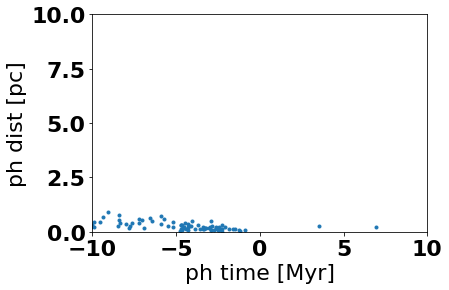

1 0.8611546884368201 (4375975468743161984, 11.3657, 16.0114, -0.531, 0.307)


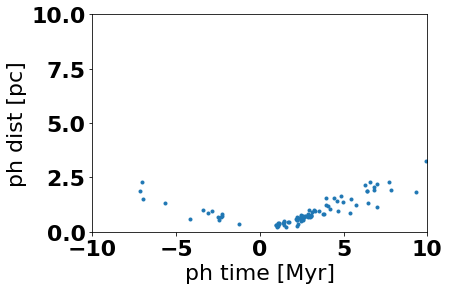

2 1.028592454920101 (5568040721167830784, 7.2292, 16.2031, 0.152, -0.124)


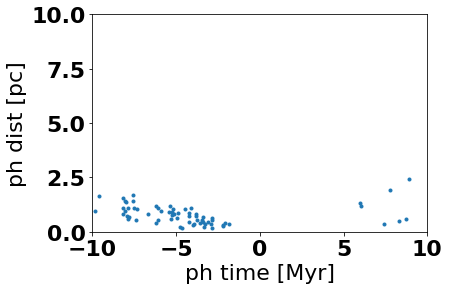

3 1.2605329501406464 (874423288127047936, 4.5607, 15.5107, -0.041, -0.02)


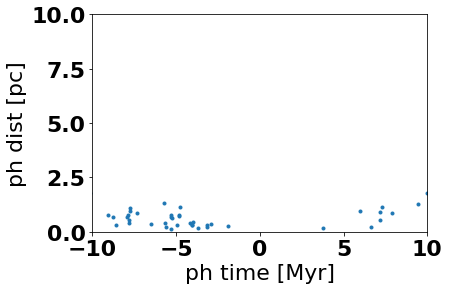

4 1.3386840268655888 (3031095348649154944, 8.5089, 15.979, -0.363, 0.412)


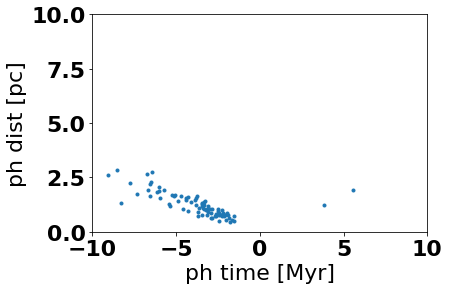

5 1.3781735718969195 (2024985481361040384, 33.1141, 13.7012, -5.477, -3.456)


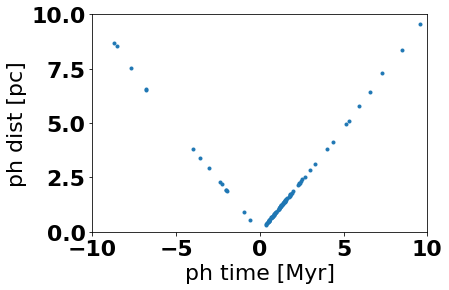

6 1.3852244542353063 (2232697418358999040, 4.1172, 15.4205, -0.093, 0.049)


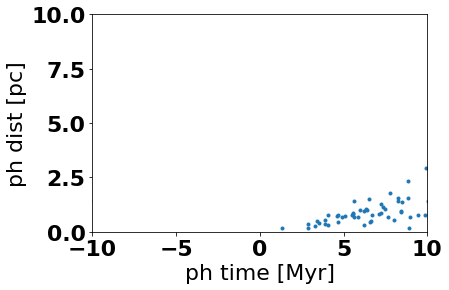

7 1.517786514329137 (4613877211959795584, 9.9162, 16.3663, 0.152, -0.486)


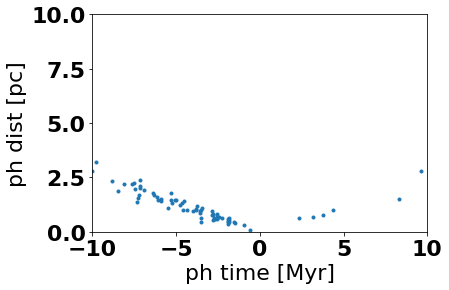

8 1.5290072553351985 (3207554389235614720, 24.0703, 16.0947, -2.168, 3.421)


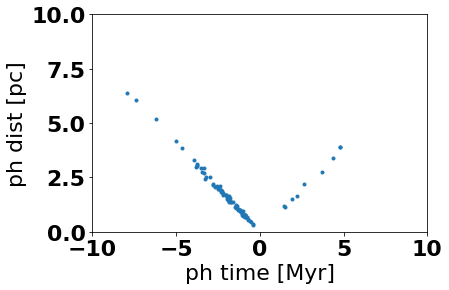

9 1.5888740008582292 (6734773981634003456, 21.5352, 16.3367, -0.948, 3.053)


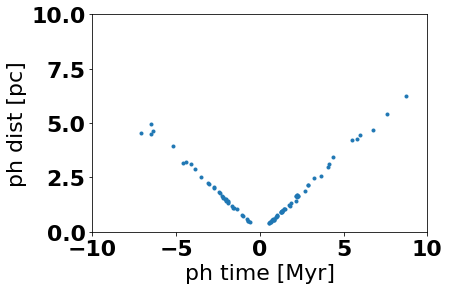

<Figure size 432x288 with 0 Axes>

In [96]:
percentile = 50
sort = np.argsort(sampled_perihelia[:,0,percentile])
sampled_perihelia = sampled_perihelia[sort]
fol = fol[sort]
for i in range(10):
    print(i, sampled_perihelia[i,0,percentile],fol[i][['source_id','parallax','phot_g_mean_mag','pmra','pmdec']])
    plt.plot(sampled_perihelia[i,1,:],sampled_perihelia[i,0,:],'.')
    plt.ylabel('ph dist [pc]')
    plt.xlabel('ph time [Myr]')
    plt.xlim((-10,10))
    plt.ylim((0,10))
    plt.show()
    plt.clf()

- Now we have a list of good candidates
- For those we should redo that task with more samples and orbit calculation
- We need to check if radial velocity measurements have been already done for those stars in some other catalog
- So let's have a last look at our targets in [Simbad](http://simbad.u-strasbg.fr/simbad/sim-fcoo)
- Write the proposal...